# Read libraries

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from copy import copy, deepcopy
from pathlib import Path
from sys import path

path.append( str(Path.cwd().parent) )

In [2]:
import json
import re

import matplotlib.pyplot as plt
import pandas as pd

from collections import Counter
from matplotlib.gridspec import GridSpec
from numpy import arange, array, exp, isnan, log
from statsmodels.formula.api import ols
from string import punctuation, whitespace


from Project_libraries.my_stats import ( half_frame, place_commas )
from Project_libraries.pubmed import ( get_time_series, plot_time_series,
                                       classify_articles, 
                                       count_articles_by_journal,
                                       get_articles_by_publisher,
                                       plot_for_publications,
                                       plot_for_problems,
                                     )

# Load journal catalogue

In [3]:
catalogue_file = Path.cwd() / 'Project_libraries' / 'journal_catalogue.json'

with open(catalogue_file, 'r', encoding = 'utf-8') as file_in:
    catalogue = json.load(file_in)

In [4]:
#Check number of journals without information
#
count = 0
for journal in catalogue:
    if catalogue[journal]['publisher'] is None:
        count += 1
        
        
print(f"There are {len(catalogue)} items in the Journal Catalogue.\n\n"
      f"We lack publisher information for {count} journals.")



There are 6654 items in the Journal Catalogue.

We lack publisher information for 1778 journals.


In [5]:
publisher_list = []
for journal in catalogue:
    if catalogue[journal]:
        publisher = catalogue[journal]['publisher'] 
        if publisher not in publisher_list:
            publisher_list.append(publisher )

print(publisher_list)
publisher_list.remove(None)


['Springer Nature', 'IMR Press', 'British Medical Association', None, 'Elsevier', 'Wiley', 'IOS Press', 'Wolters Kluwer', 'American Association for Cancer Research', 'Oxford University Press', 'American Medical Informatics Association', 'Future Science', 'American Medical Association', 'Taylor & Francis', 'Cold Spring Harbor Laboratory Press', 'Mary Ann Liebert', 'PLoS', 'Spandidos', 'American Society of Clinical Oncology', 'De Gruyter', 'Hindawi', 'Canadian Medical Association', 'Cambridge University Press', 'Karger', 'MDPI', 'American College of Physicians', 'Bentham', 'AAAS', 'National Academy of Sciences', 'Zhonghua yi xue hui', 'Lancet', 'Sage', 'American Medical Pub', 'Slovak Academic Press', 'Cell Press', 'Impact Journals', 'CRC Press', 'International Institute of Anticancer Research', 'Biochemical Society', 'Chinese Medical Association', 'Future Science Group', 'American Public Health Association', 'American Chemical Society', 'Meditsina', 'JoVE', 'Royal Australian College of G

# Import articles

In [7]:
cwd = Path.cwd()
aux = cwd.glob('Case_*')

cases = []
for case in aux:
    cases.append( case.parts[-1] )
    
cases.sort()

for i in range(len(cases)):
    print(f"{i:>2} -- {cases[i]}")

 0 -- Case_brain_cancer_stem_cells
 1 -- Case_brca2
 2 -- Case_chest_imaging_pneumonia
 3 -- Case_circular_rna
 4 -- Case_crispr_cas9
 5 -- Case_deep_learning_tumor
 6 -- Case_graphene_sensors
 7 -- Case_green_synthesis_np
 8 -- Case_green_synthesis_silver_np
 9 -- Case_lncrna
10 -- Case_mirna_cancer
11 -- Case_mirna_development
12 -- Case_prions
13 -- Case_rnai_cancer
14 -- Case_skin_wound_healing
15 -- Case_statins_cancer
16 -- Case_trna_cancer
17 -- Case_trna_development


In [164]:
my_parameters = [{'folder': cwd / 'Case_brain_cancer_stem_cells', 
                  'year1': 1992, 'year2': 2020, 'min_size': 100, 'add_fit': True},
                 {'folder': cwd / 'Case_brca2', 
                  'year1': 1994, 'year2': 2020, 'min_size': 150, 'add_fit': True},
                 {'folder': cwd / 'Case_chest_imaging_pneumonia', 
                  'year1': 2008, 'year2': 2020, 'min_size': 100, 'add_fit': False},
                 {'folder': cwd / 'Case_circular_rna',
                  'year1': 2008, 'year2': 2020, 'min_size': 250, 'add_fit': False},
                 {'folder': cwd / 'Case_crispr_cas9',
                  'year1': 2012, 'year2': 2020, 'min_size': 100, 'add_fit': False},
                 {'folder': cwd / 'Case_deep_learning_tumor',
                  'year1': 2012, 'year2': 2020, 'min_size': 100, 'add_fit': False},
                 {'folder': cwd / 'Case_graphene_sensors',
                  'year1': 2004, 'year2': 2020, 'min_size': 60, 'add_fit': False},
                 {'folder': cwd / 'Case_green_synthesis_np',
                  'year1': 2004, 'year2': 2020, 'min_size': 90, 'add_fit': False},
                 {'folder': cwd / 'Case_green_synthesis_silver_np',
                  'year1': 2004, 'year2': 2020, 'min_size': 60, 'add_fit': False},
                 {'folder': cwd / 'Case_lncrna',
                  'year1': 2008, 'year2': 2020, 'min_size': 400, 'add_fit': False},
                 {'folder': cwd / 'Case_mirna_cancer',
                  'year1': 2004, 'year2': 2020, 'min_size': 650, 'add_fit': False},
                 {'folder': cwd / 'Case_mirna_development',
                  'year1': 2004, 'year2': 2020, 'min_size': 400, 'add_fit': False},
                 {'folder': cwd / 'Case_prions',
                  'year1': 1984, 'year2': 2020, 'min_size': 400, 'add_fit': True},
                 {'folder': cwd / 'Case_rnai_cancer',
                  'year1': 2002, 'year2': 2020, 'min_size': 70, 'add_fit': False},
                 {'folder': cwd / 'Case_skin_wound_healing',
                  'year1': 2000, 'year2': 2020, 'min_size': 75, 'add_fit': True},
                 {'folder': cwd / 'Case_statins_cancer',
                  'year1': 1992, 'year2': 2020, 'min_size': 90, 'add_fit': False},
                ]

In [148]:
print(my_parameters[3])

{'folder': PosixPath('/Users/amaral/Dropbox/Code_Development/Projects/Science_fraud_topic_analysis/Case_circular_rna'), 'year1': 2008, 'year2': 2024, 'min_size': 250, 'add_fit': False}


In [149]:
case = my_parameters[3]
print(f"We will be processing the data in folder '{case['folder'].parts[-1]}'.\n")

case_folder = case['folder']

articles_file = case_folder / 'articles_clean.json'
png_file = case_folder / 'time_series.png'



We will be processing the data in folder 'Case_circular_rna'.



In [150]:
with open(articles_file, 'r', encoding = 'utf-8') as f_json:
    articles = json.load(f_json)
    
print( f"There are {place_commas(len(articles))} articles in the "
       f"'{case['folder'].parts[-1]}' collection.\n" )


There are 18,192 articles in the 'Case_circular_rna' collection.



In [151]:
print( f"We are verifying publisher information for "
       f"{place_commas(len(articles))} articles.\n" )

no_info = []
for i, article in enumerate( articles ):
    journal = article['journal']
    
    journal_info = catalogue[journal]
    
    # We lack info for some journals
    #
    if journal_info['publisher'] is None:
        no_info.append(i)
        for key in ['publisher', 'start_date', 'mesh']:
            article[key] = None

        continue
    
    for key in ['publisher', 'start_date', 'mesh']:
        if key not in journal_info.keys():
            article[key] = None
        else:
            article[key] = journal_info[key]
        
    
print(f"Finished processing all articles.\n\n"
      f"We lack publisher information for {place_commas(len(no_info))} articles.")



We are verifying publisher information for 18,192 articles.

Finished processing all articles.

We lack publisher information for 1,410 articles.


## Calculate breakdown by publisher

In [152]:
publishers = []
for article in articles:
    if 'publisher' in article.keys():
        publishers.append( article['publisher'] )
    
counter = Counter(publishers)

counter.most_common(20)

[('Springer Nature', 3275),
 ('Elsevier', 2995),
 ('Taylor & Francis', 1828),
 ('Wiley', 1664),
 (None, 1410),
 ('Frontiers', 992),
 ('MDPI', 889),
 ('Oxford University Press', 702),
 ('American Chemical Society', 373),
 ('Spandidos', 346),
 ('Cell Press', 337),
 ('Wolters Kluwer', 306),
 ('Hindawi', 299),
 ('PLoS', 262),
 ('Impact Journals', 240),
 ('American Society for Microbiology', 187),
 ('Sage', 158),
 ('Verduci', 151),
 ('Mary Ann Liebert', 147),
 ('Royal Society of Chemistry', 119)]

In [153]:
count_articles_by_journal(get_articles_by_publisher(articles, None), 30)

[('Int J Syst Evol Microbiol', 225),
 ('Plant Dis', 65),
 ('PeerJ', 55),
 ('Theranostics', 43),
 ('Histol Histopathol', 38),
 ('Metab Brain Dis', 33),
 ('J Bacteriol', 30),
 ('Int J Med Sci', 27),
 ('J Gen Virol', 26),
 ('Clin Transl Oncol', 25),
 ('Cell Mol Biol (Noisy-le-grand)', 19),
 ('Nucleic Acids Symp Ser (Oxf)', 19),
 ('Genes Genomics', 17),
 ('Ann Clin Lab Sci', 14),
 ('Gut', 14),
 ('Clin Lab', 13),
 ('Minerva Med', 13),
 ('bioRxiv [Preprint]', 13),
 ('Nan Fang Yi Ke Da Xue Xue Bao', 12),
 ('J Microbiol', 12),
 ('Zhonghua Gan Zang Bing Za Zhi', 12),
 ('Biochemistry (Mosc)', 11),
 ('Genet Mol Res', 11),
 ('J BUON', 10),
 ('Int Heart J', 10),
 ('J Microbiol Biotechnol', 10),
 ('Mol Plant Microbe Interact', 10),
 ('Phytopathology', 9),
 ('Microbiol Spectr', 8),
 ('Life Sci Alliance', 8)]

# Analyze data for entire set of articles

In [154]:
year0 = case['year1']
year1 = case['year2']

pattern1 = 'review'
pattern2 = 'reviewed'

# Full set 
#
output = classify_articles( articles, 'FULL' )
no_abstract_all, retracted_all, erratum_all, commented_all = output

# Review articles set
#
review_articles = []
for article in articles:
    if article['abstract']:
        if ( pattern1 in article['abstract'].lower() 
             or pattern2 in article['abstract'].lower() ):
            review_articles.append( article )

output = classify_articles( review_articles, 'REVIEW' )
no_abstract_review, retracted_review, erratum_review, commented_review = output


# No review articles set
#
no_review_articles = []
for article in articles:
    if article['abstract']:
        if not ( pattern1 in article['abstract'].lower() 
                 or pattern2 in article['abstract'].lower() ):
            no_review_articles.append( article )

output = classify_articles( no_review_articles, 'NO REVIEW' )
no_abstract_norev, retracted_norev, erratum_norev, commented_norev = output


# Create dataframe with time series 
#
df_time_series = pd.DataFrame( {'Year': array(range(year0, year1)), 
                                'Full Set Papers': get_time_series(pd.DataFrame(articles), year0, year1),
                                'FS Retracted': get_time_series(pd.DataFrame(retracted_all), year0, year1), 
                                'FS Errata': get_time_series(pd.DataFrame(erratum_all), year0, year1),
                                'FS Comments': get_time_series(pd.DataFrame(commented_all), year0, year1),
                                'Review Papers': get_time_series(pd.DataFrame(review_articles), year0, year1),
                                'Rev Retracted': get_time_series(pd.DataFrame(retracted_review), year0, year1), 
                                'Rev Errata': get_time_series(pd.DataFrame(erratum_review), year0, year1),
                                'Rev Comments': get_time_series(pd.DataFrame(commented_review), year0, year1),
                                'No Review Papers': get_time_series(pd.DataFrame(no_review_articles), year0, year1),
                                'NoRev Retracted': get_time_series(pd.DataFrame(retracted_norev), year0, year1), 
                                'NoRev Errata': get_time_series(pd.DataFrame(erratum_norev), year0, year1),
                                'NoRev Comments': get_time_series(pd.DataFrame(commented_norev), year0, year1),
                               } )

df_time_series




There are 18192 articles in the 'FULL' set.
169 have no abstract; 
193 have been retracted; 
308 have had errata published; and 
41 have had comments written about them.


There are 2043 articles in the 'REVIEW' set.
0 have no abstract; 
1 have been retracted; 
18 have had errata published; and 
2 have had comments written about them.


There are 15980 articles in the 'NO REVIEW' set.
0 have no abstract; 
191 have been retracted; 
289 have had errata published; and 
37 have had comments written about them.




,Year,Full Set Papers,FS Retracted,FS Errata,FS Comments,Review Papers,Rev Retracted,Rev Errata,Rev Comments,No Review Papers,NoRev Retracted,NoRev Errata,NoRev Comments
0,2008,183,0,2,1,7,0,0,0,174,0,2,1
1,2009,187,0,0,0,2,0,0,0,184,0,0,0
2,2010,193,0,3,1,6,0,0,1,185,0,3,0
3,2011,185,0,3,0,3,0,0,0,182,0,3,0
4,2012,240,0,4,0,7,0,0,0,233,0,4,0
5,2013,277,3,2,0,12,0,0,0,260,3,2,0
6,2014,288,0,4,0,13,0,0,0,273,0,4,0
7,2015,358,0,9,2,28,0,0,0,327,0,9,2
8,2016,644,1,11,1,39,0,0,0,600,1,11,1
9,2017,658,2,15,7,70,0,0,0,581,2,15,7


## Calculate ratios and plot data

/Users/amaral/anaconda3/envs/new_base/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


                            OLS Regression Results                            
Dep. Variable:              ln_Papers   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.924
Method:                 Least Squares   F-statistic:                     183.1
Date:                Fri, 03 May 2024   Prob (F-statistic):           1.97e-09
Time:                        16:00:30   Log-Likelihood:                -2.6616
No. Observations:                  16   AIC:                             9.323
Df Residuals:                      14   BIC:                             10.87
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -445.4799     33.393    -13.341      0.0

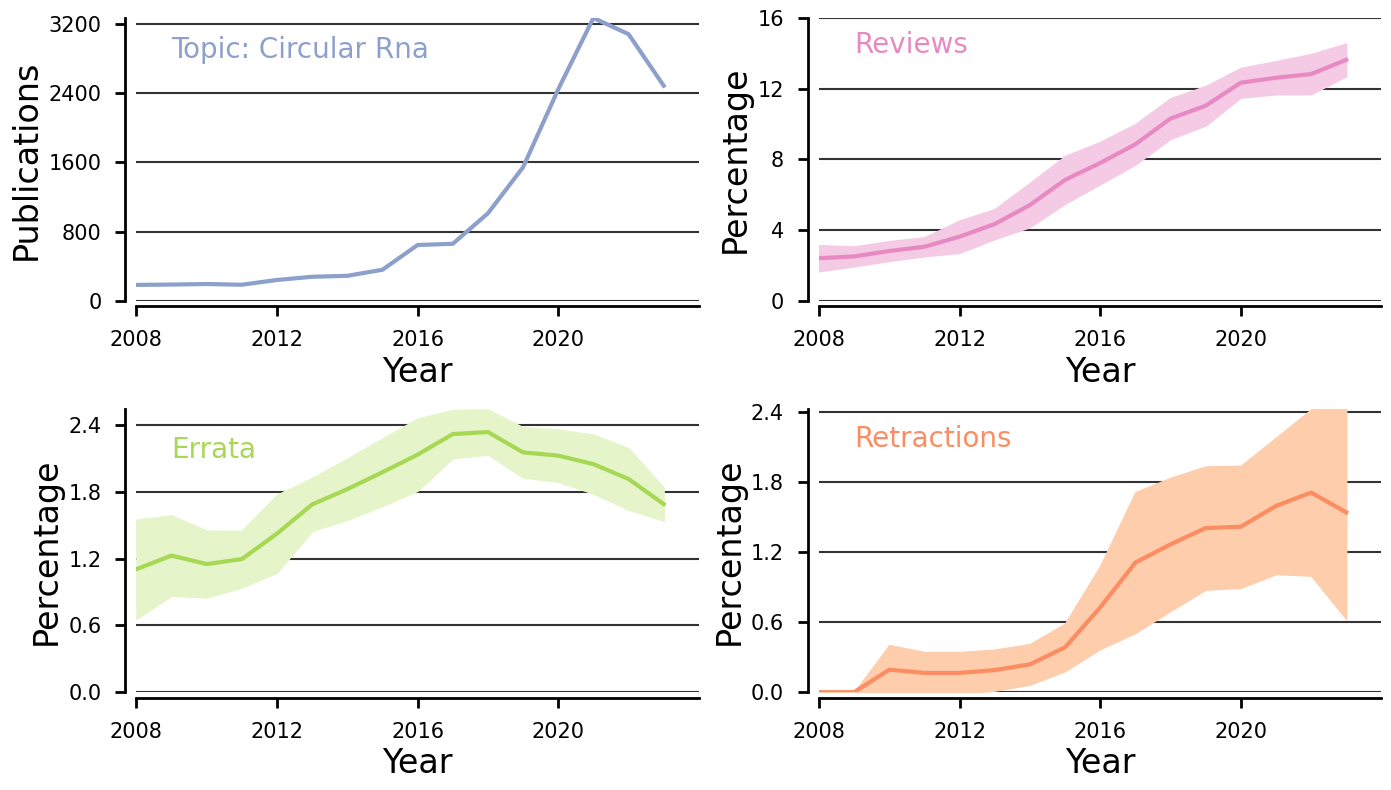

In [155]:
# Calculate ratios
#
key = 'Review Papers'
column = f"{key}_ratio"
df_time_series[column] = df_time_series[key] / df_time_series['Full Set Papers']
    
for key in [ 'NoRev Retracted', 'NoRev Errata', 'NoRev Comments' ]:
    column = f"{key}_ratio"
    df_time_series[column] = df_time_series[key] / df_time_series['No Review Papers']

    
# Plot data
#
add_fit = case['add_fit']
colors = { 'Papers': '#8da0cb', 'Retracted': '#fc8d62', 'Reviews': '#e78ac3',
           'Errata': '#a6d854', 'Comments': '#66c2a5', }

colors_b = { 'Papers': '#cbd5e8', 'Retracted': '#fdcdac', 'Reviews': '#f4cae4',
             'Errata': '#e6f5c9', 'Comments': '#b3e2cd', }

folder = str(case_folder)[77:]

fig = plt.figure( figsize = (14, 8) )
ax = []

ax.append(fig.add_subplot(221))
plot_time_series( ax[-1], df_time_series, 'Full Set Papers', 1, 
                         folder.replace('_', ' '), colors['Papers'], 
                         colors_b['Papers'] )

# ax[-1].semilogy()
# Add exponential fit
df_time_series['ln_Papers'] = log(df_time_series['Full Set Papers'])
model = ols( formula = 'ln_Papers ~ Year', data = df_time_series)
results = model.fit()
print(results.summary())
if add_fit:
    ax[-1].plot( df_time_series.Year, 
                 exp(results.params.Intercept + results.params.Year * df_time_series.Year),
                 lw = 3, color = '0.2', zorder = -3)

ax.append(fig.add_subplot(222))
plot_time_series( ax[-1], df_time_series, 'Review Papers_ratio', 7, 
                        'Reviews', colors['Reviews'], 
                        colors_b['Reviews'] )

ax.append(fig.add_subplot(224))
plot_time_series( ax[-1], df_time_series, 'NoRev Retracted_ratio', 7, 
                        'Retractions', colors['Retracted'], 
                        colors_b['Retracted'] )

ax.append(fig.add_subplot(223))
# plot_time_series( ax[-1], df_time_series, 'NoRev Comments_ratio', 5, 
#                          'Comments', colors['Comments'], 
#                         colors_b['Comments'] )

plot_time_series( ax[-1], df_time_series, 'NoRev Errata_ratio', 7, 
                        'Errata', colors['Errata'], 
                        colors_b['Errata'] )

plt.tight_layout()

plt.savefig(png_file)

# Analyze trends by journal


There are 208 articles in the set for Biochem Biophys Res Commun
There are 208 articles in the 'FULL' set.
0 have no abstract; 
1 have been retracted; 
6 have had errata published; and 
0 have had comments written about them.


There are 1 articles in the 'REVIEW' set.
0 have no abstract; 
0 have been retracted; 
0 have had errata published; and 
0 have had comments written about them.


There are 207 articles in the 'NO REVIEW' set.
0 have no abstract; 
1 have been retracted; 
6 have had errata published; and 
0 have had comments written about them.



There are 245 articles in the set for Nucleic Acids Res
There are 245 articles in the 'FULL' set.
0 have no abstract; 
0 have been retracted; 
2 have had errata published; and 
0 have had comments written about them.


There are 1 articles in the 'REVIEW' set.
0 have no abstract; 
0 have been retracted; 
0 have had errata published; and 
0 have had comments written about them.


There are 244 articles in the 'NO REVIEW' set.
0 have no 

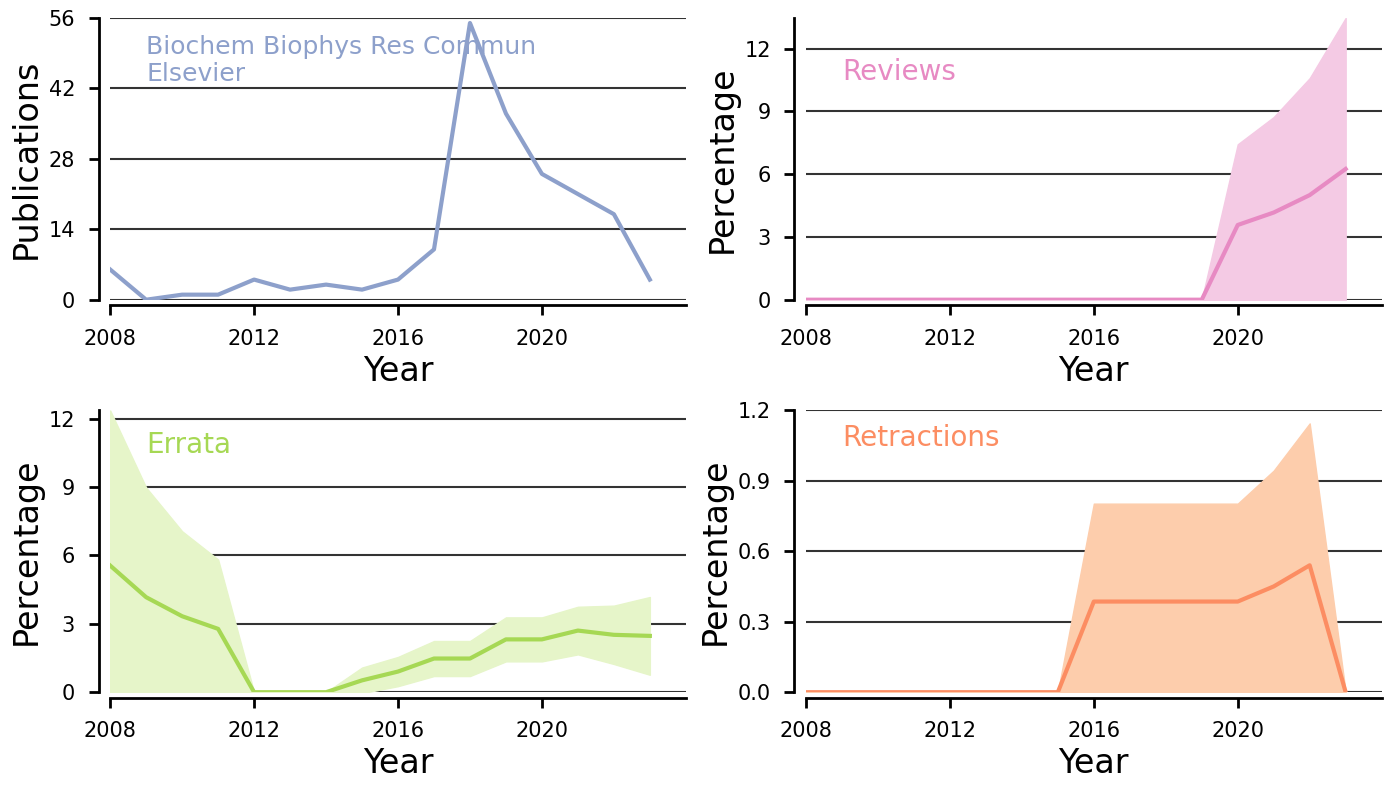

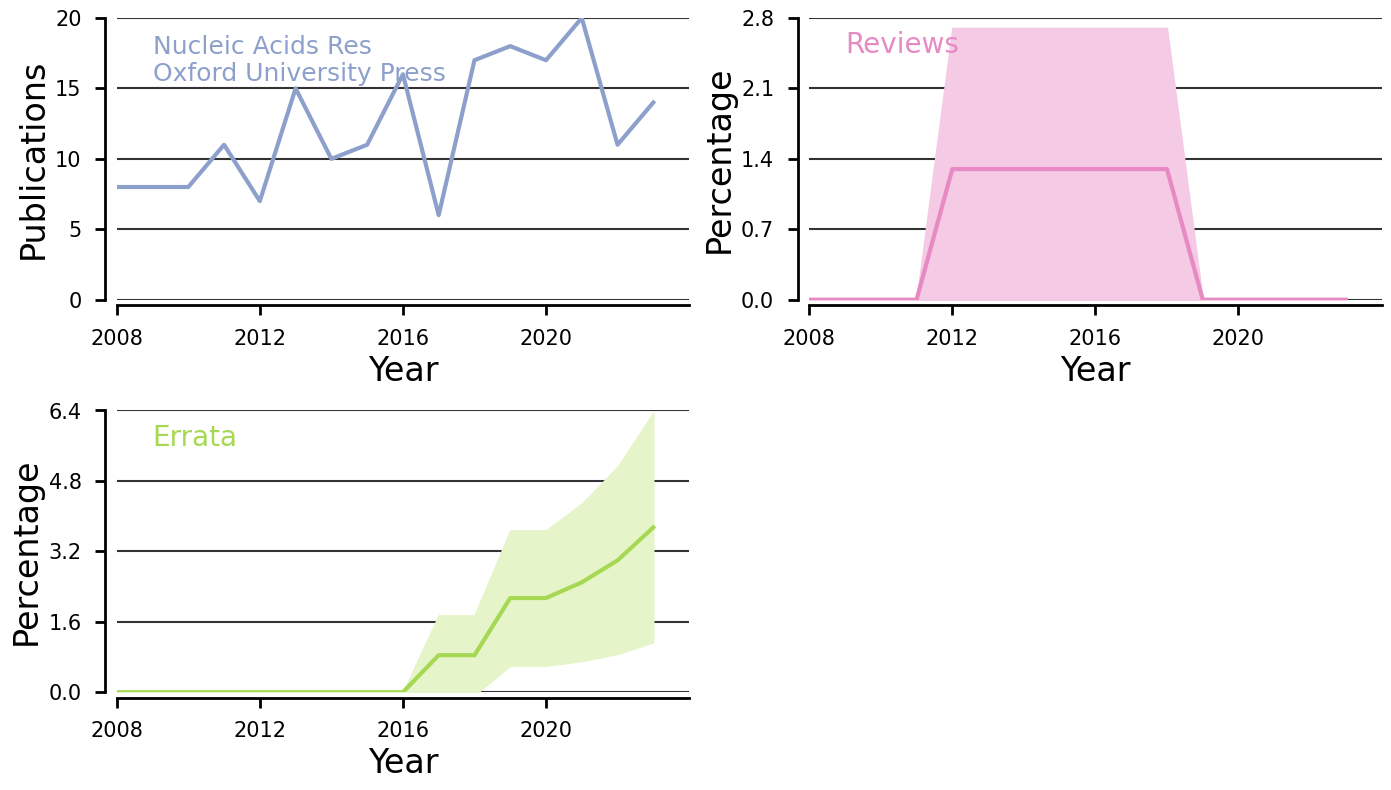

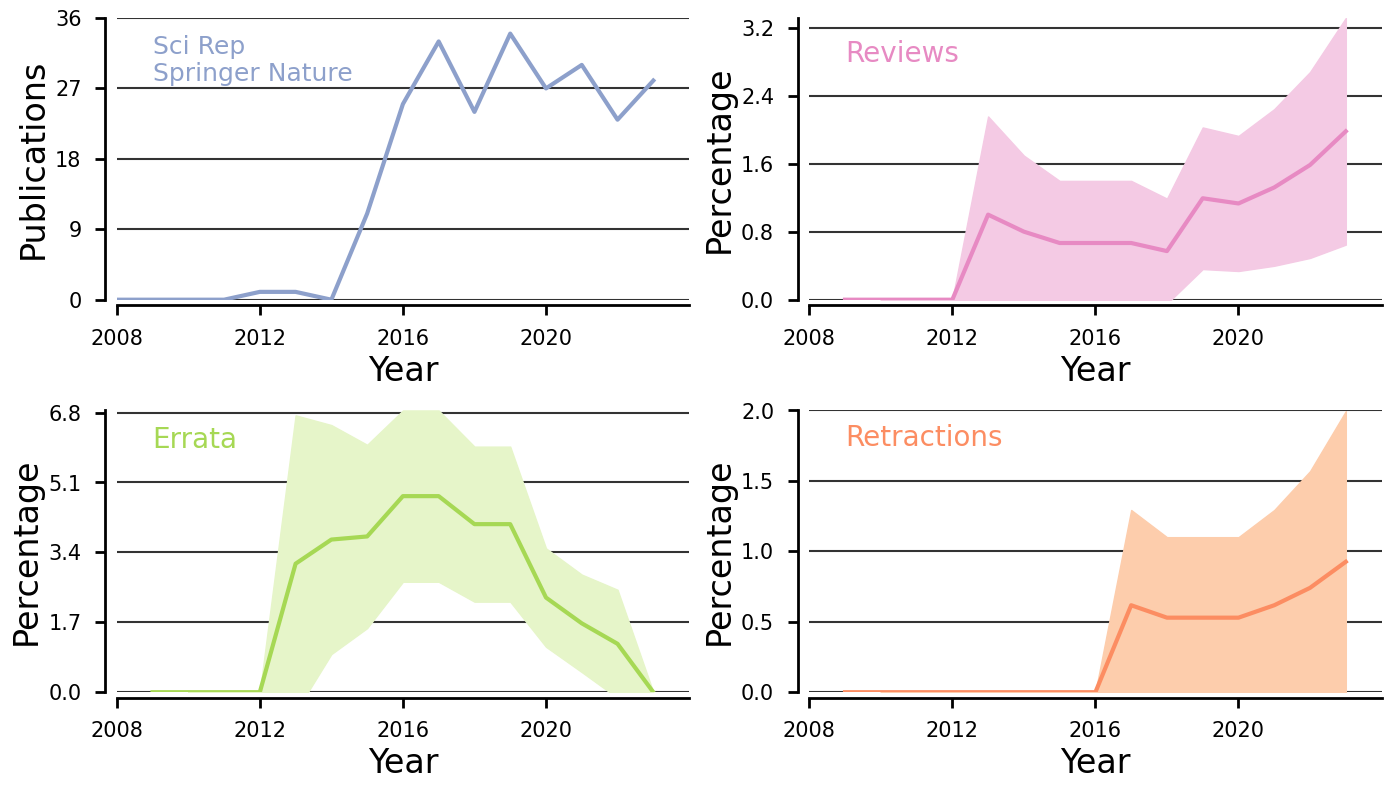

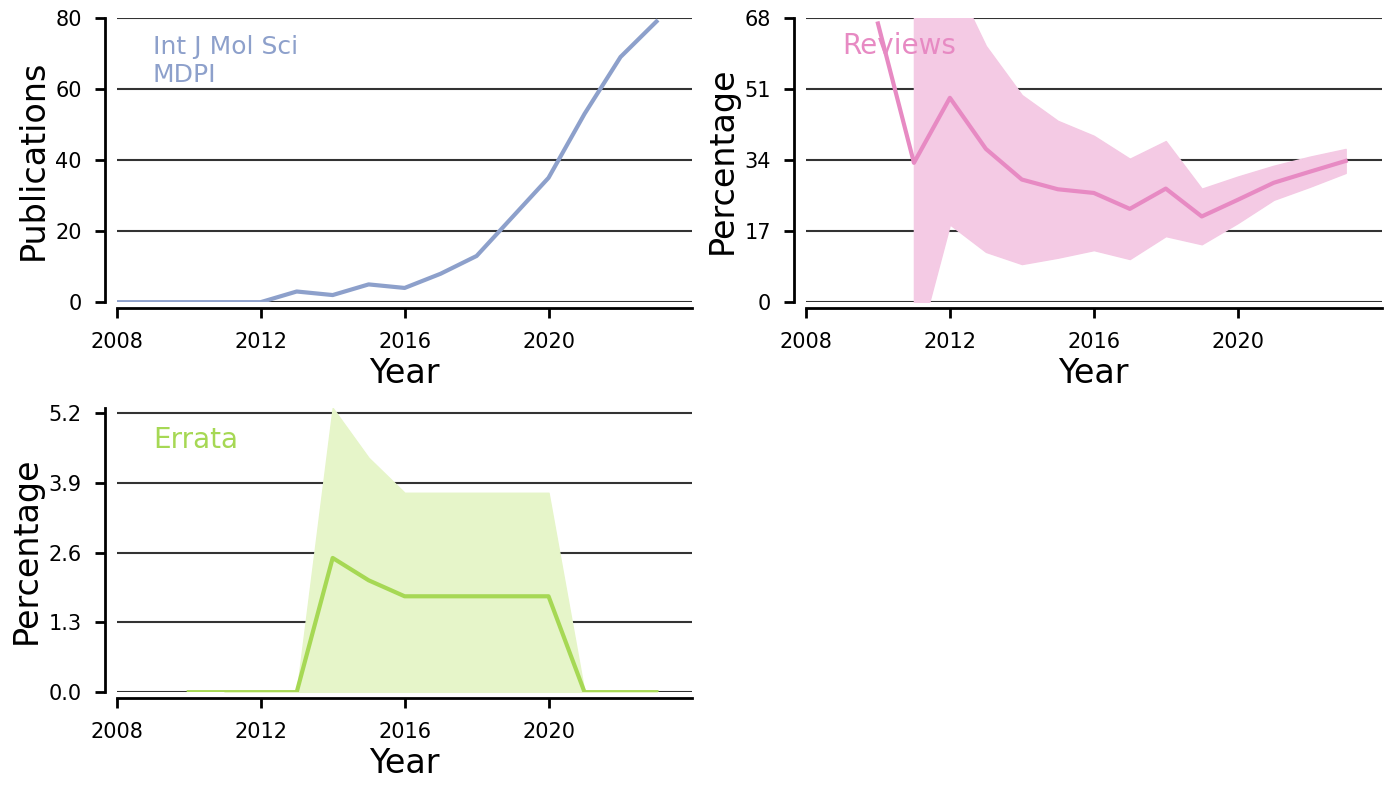

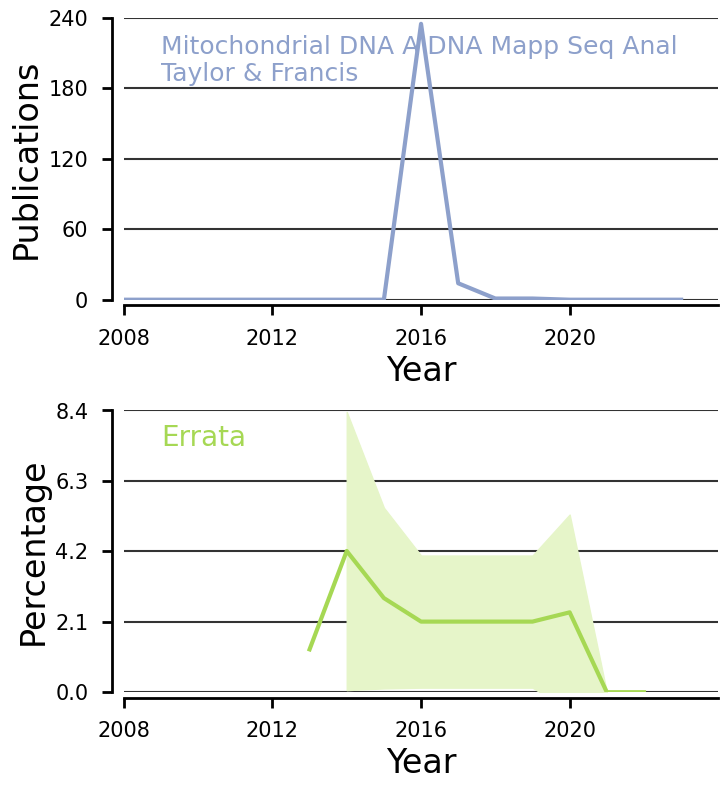

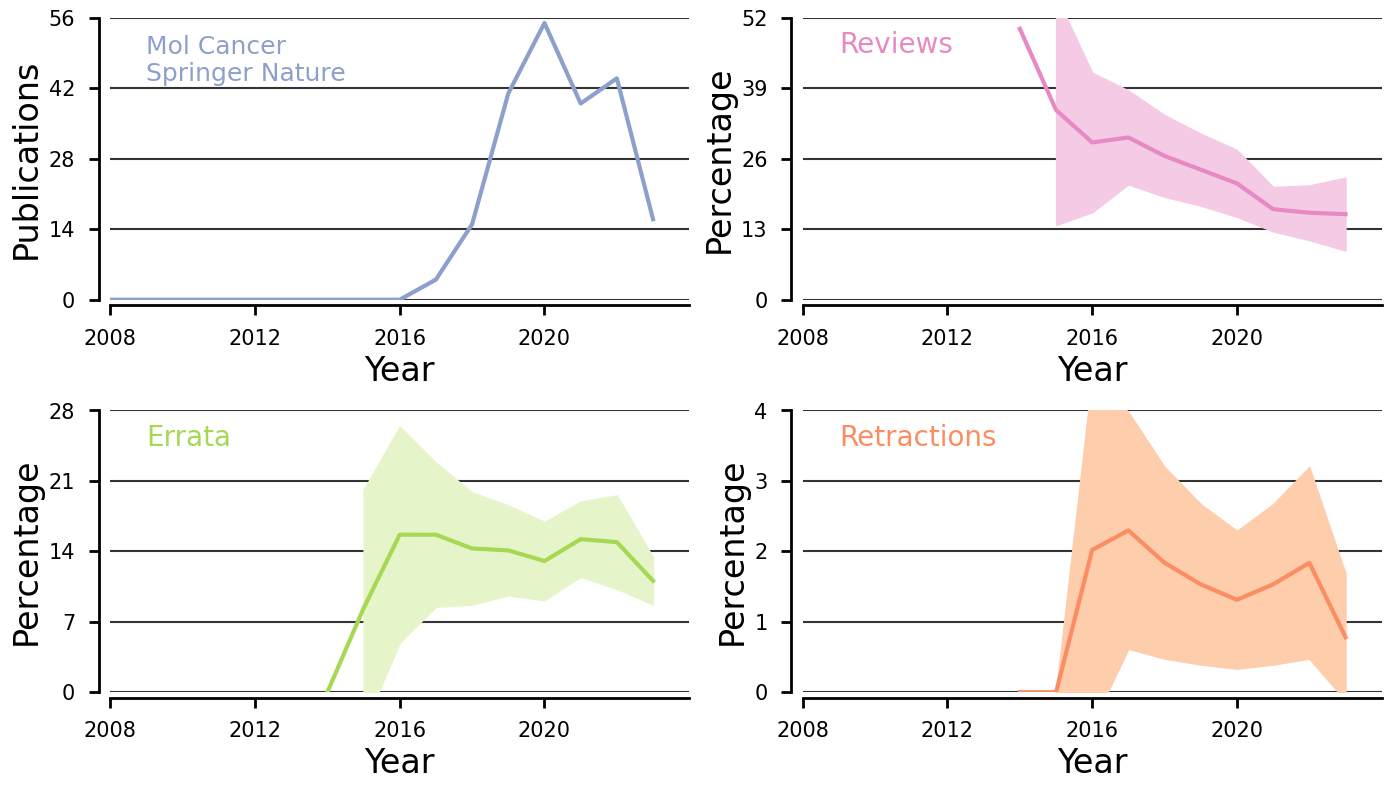

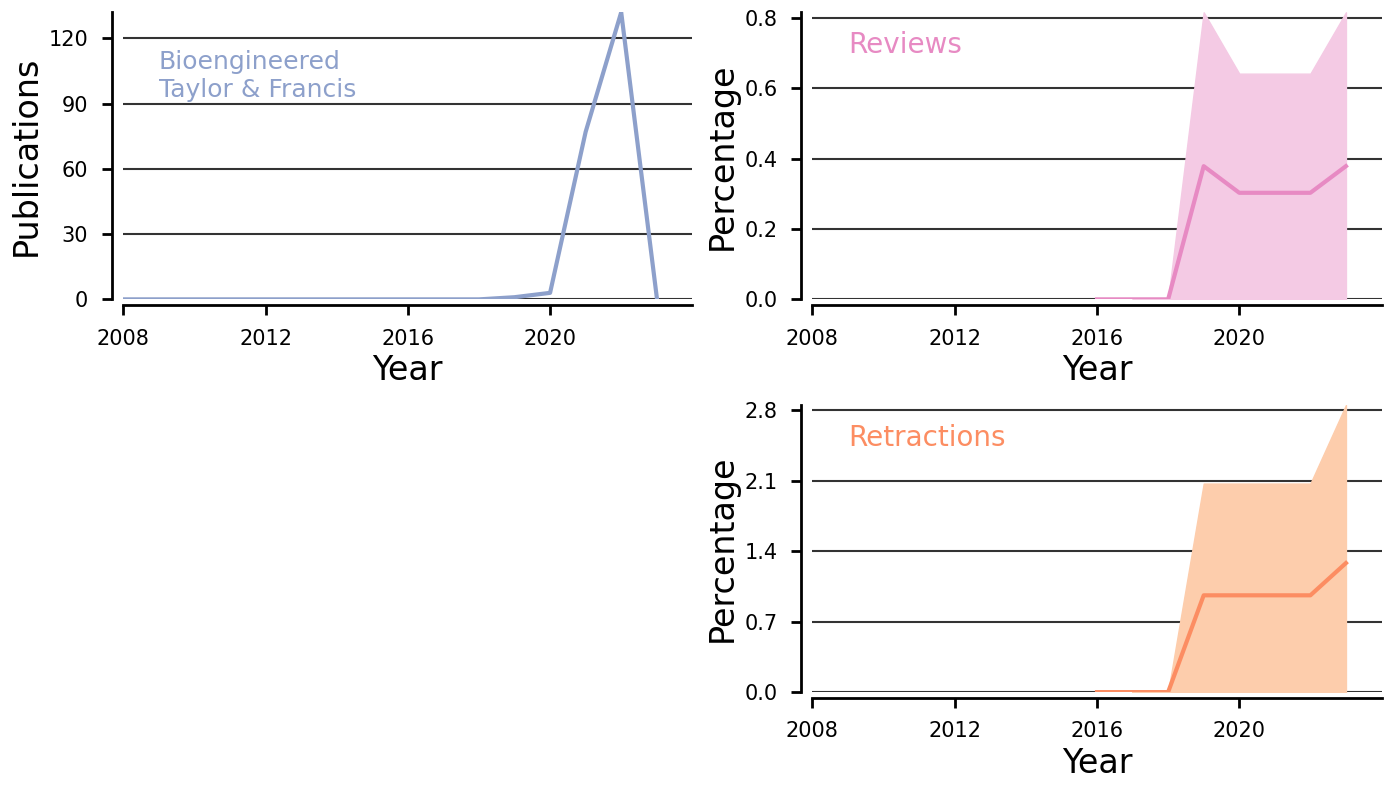

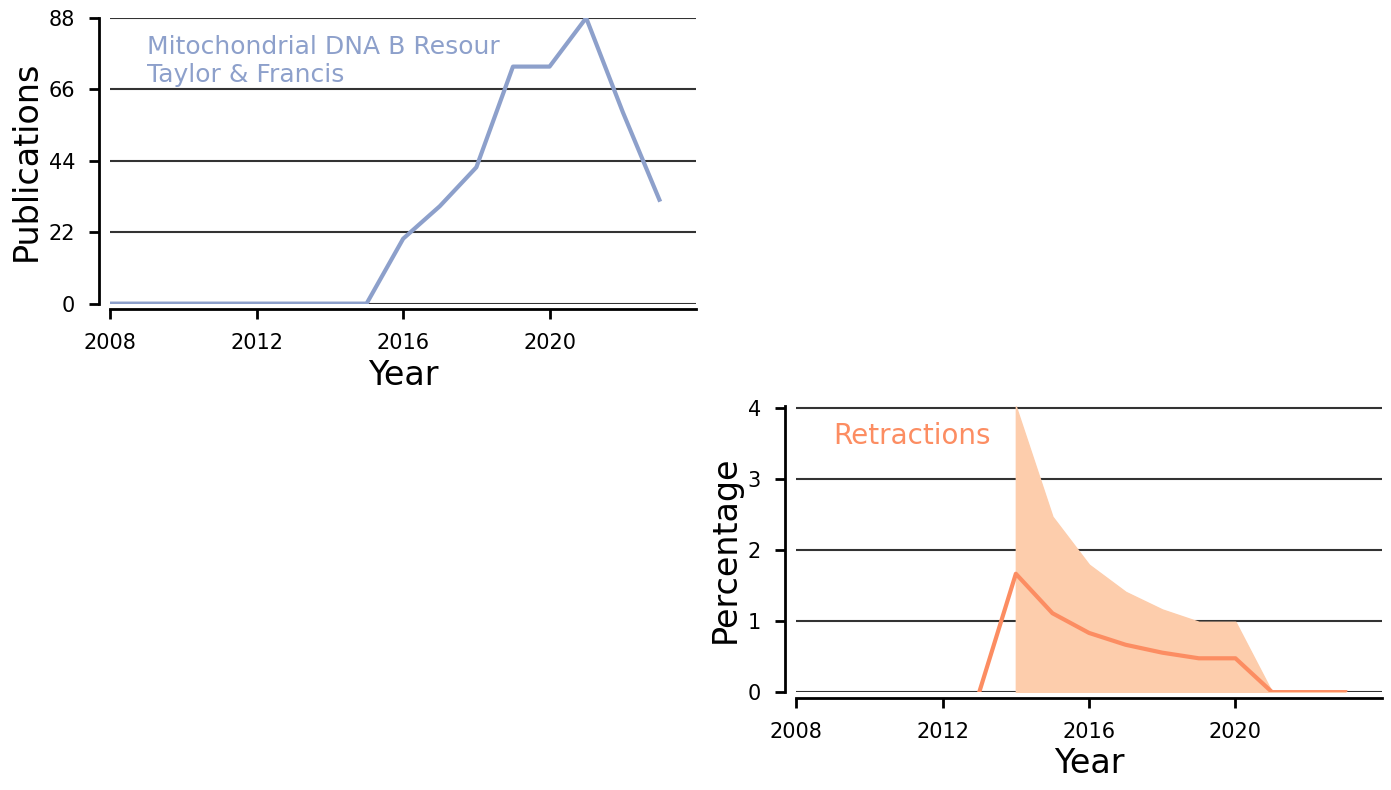

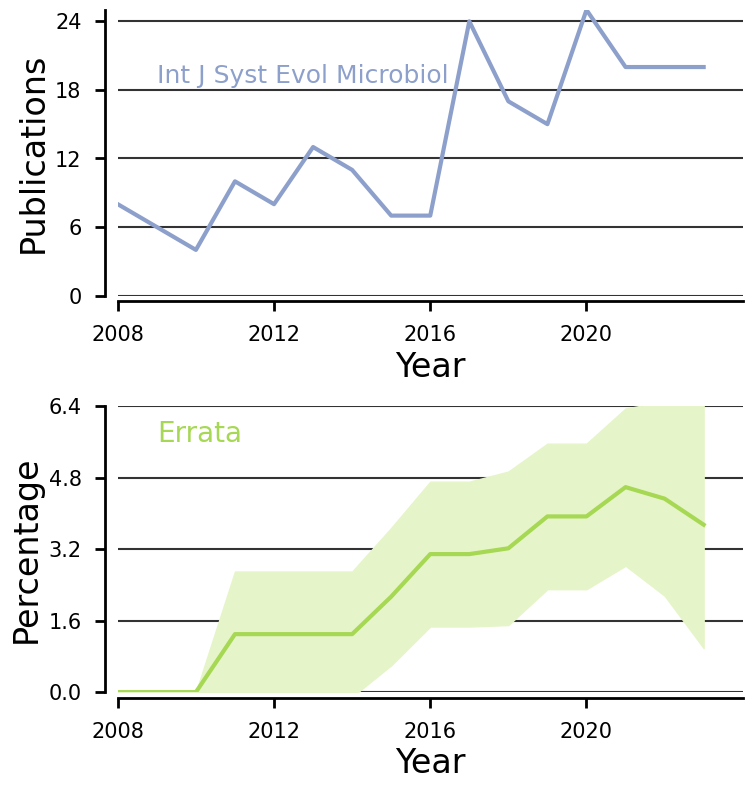

In [156]:
min_size = case['min_size']

for journal in catalogue: 
    target_articles = []
    for article in articles:
        if article['journal'] == journal:
            target_articles.append( article )    

    if len(target_articles) < min_size * 0.8:
        continue
        
    print(f"\nThere are {len(target_articles)} articles in the set for "
          f"{journal}")

    pattern1 = 'review'
    pattern2 = 'reviewed'

    # Full set 
    #
    output = classify_articles( target_articles, 'FULL' )
    no_abstract_all, retracted_all, erratum_all, commented_all = output

    # Review articles set
    #
    review_articles = []
    for article in target_articles:
        if article['abstract']:
            if ( pattern1 in article['abstract'].lower() 
                 or pattern2 in article['abstract'].lower() ):
                review_articles.append( article )

    output = classify_articles( review_articles, 'REVIEW' )
    no_abstract_review, retracted_review, erratum_review, commented_review = output

    # No review articles set
    #
    no_review_articles = []
    for article in target_articles:
        if article['abstract']:
            if not ( pattern1 in article['abstract'].lower() 
                     or pattern2 in article['abstract'].lower() ):
                no_review_articles.append( article )

    output = classify_articles( no_review_articles, 'NO REVIEW' )
    no_abstract_norev, retracted_norev, erratum_norev, commented_norev = output

    df_target = pd.DataFrame( {'Year': array(range(year0, year1)), 
                                'Full Set Papers': get_time_series(pd.DataFrame(target_articles), year0, year1),
                                'FS Retracted': get_time_series(pd.DataFrame(retracted_all), year0, year1), 
                                'FS Errata': get_time_series(pd.DataFrame(erratum_all), year0, year1),
                                'FS Comments': get_time_series(pd.DataFrame(commented_all), year0, year1),
                                'Review Papers': get_time_series(pd.DataFrame(review_articles), year0, year1),
                                'Rev Retracted': get_time_series(pd.DataFrame(retracted_review), year0, year1), 
                                'Rev Errata': get_time_series(pd.DataFrame(erratum_review), year0, year1),
                                'Rev Comments': get_time_series(pd.DataFrame(commented_review), year0, year1),
                                'No Review Papers': get_time_series(pd.DataFrame(no_review_articles), year0, year1),
                                'NoRev Retracted': get_time_series(pd.DataFrame(retracted_norev), year0, year1), 
                                'NoRev Errata': get_time_series(pd.DataFrame(erratum_norev), year0, year1),
                                'NoRev Comments': get_time_series(pd.DataFrame(commented_norev), year0, year1),
                               } )

    key = 'Review Papers'
    column = f"{key}_ratio"
    df_target[column] = df_target[key] / df_target['Full Set Papers']

    for key in [ 'NoRev Retracted', 'NoRev Errata', 'NoRev Comments' ]:
        column = f"{key}_ratio"
        df_target[column] = df_target[key] / df_target['No Review Papers']

    colors = { 'Papers': '#8da0cb', 'Retracted': '#fc8d62', 'Reviews': '#e78ac3',
               'Errata': '#a6d854', 'Comments': '#66c2a5', }

    colors_b = { 'Papers': '#cbd5e8', 'Retracted': '#fdcdac', 'Reviews': '#f4cae4',
                 'Errata': '#e6f5c9', 'Comments': '#b3e2cd', }

    fig = plt.figure( figsize = (14, 8) )
    ax = []


    ax.append(fig.add_subplot(221))
    if catalogue[journal] and catalogue[journal]['publisher']:
        my_label = '\n'.join([journal, catalogue[journal]['publisher']])
    else:
        my_label = journal
    plot_time_series( ax[-1], df_target, 'Full Set Papers', 1, 
                      my_label,  
                      colors['Papers'], colors_b['Papers'] )

    if df_target['Review Papers_ratio'].count() > 0:
        ax.append(fig.add_subplot(222))
        plot_time_series( ax[-1], df_target, 'Review Papers_ratio', 7, 
                          'Reviews', colors['Reviews'], 
                          colors_b['Reviews'] )

    if df_target['NoRev Retracted_ratio'].count() > 0:
        ax.append(fig.add_subplot(224))
        plot_time_series( ax[-1], df_target, 'NoRev Retracted_ratio', 7, 
                          'Retractions', colors['Retracted'], 
                          colors_b['Retracted'] )

    if df_target['NoRev Errata_ratio'].count() > 0:
        ax.append(fig.add_subplot(223))
        plot_time_series( ax[-1], df_target, 'NoRev Errata_ratio', 7, 
                          'Errata', colors['Errata'], 
                          colors_b['Errata'] )

    plt.tight_layout()
    plt.savefig(Path.cwd() / folder / 'Journals' / f"time_series_{journal}.png")

# Analyze trends by publisher



There are 13 articles in the set for AAAS

There are 1 articles in the set for AIP Publ

There are 82 articles in the set for AME Publishing

There are 0 articles in the set for Academia Brasileira De Ciencias

There are 0 articles in the set for American Academy of Family Physicians

There are 42 articles in the set for American Association for Cancer Research

There are 0 articles in the set for American Association for Laboratory Animal Science

There are 6 articles in the set for American Association of Immunologists

There are 373 articles in the set for American Chemical Society
There are 373 articles in the 'FULL' set.
1 have no abstract; 
0 have been retracted; 
3 have had errata published; and 
1 have had comments written about them.


There are 1 articles in the 'REVIEW' set.
0 have no abstract; 
0 have been retracted; 
0 have had errata published; and 
0 have had comments written about them.


There are 371 articles in the 'NO REVIEW' set.
0 have no abstract; 
0 have been r

/Users/amaral/anaconda3/envs/new_base/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)



There are 14 articles in the set for Chinese Academy of Sciences

There are 7 articles in the set for Chinese Anti-Cancer Association

There are 41 articles in the set for Chinese Medical Association

There are 105 articles in the set for Cold Spring Harbor Laboratory Press

There are 8 articles in the set for Company of Biologists

There are 0 articles in the set for Croatian Academy Of Medical Sciences

There are 64 articles in the set for De Gruyter

There are 0 articles in the set for Do Gakkai

There are 2995 articles in the set for Elsevier
There are 2995 articles in the 'FULL' set.
26 have no abstract; 
9 have been retracted; 
47 have had errata published; and 
13 have had comments written about them.


There are 423 articles in the 'REVIEW' set.
0 have no abstract; 
1 have been retracted; 
7 have had errata published; and 
1 have had comments written about them.


There are 2546 articles in the 'NO REVIEW' set.
0 have no abstract; 
7 have been retracted; 
39 have had errata pu

/Users/amaral/anaconda3/envs/new_base/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/amaral/anaconda3/envs/new_base/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)



There are 88 articles in the set for Future Science

There are 11 articles in the set for Future Science Group

There are 299 articles in the set for Hindawi
There are 299 articles in the 'FULL' set.
0 have no abstract; 
35 have been retracted; 
3 have had errata published; and 
1 have had comments written about them.


There are 28 articles in the 'REVIEW' set.
0 have no abstract; 
0 have been retracted; 
0 have had errata published; and 
0 have had comments written about them.


There are 271 articles in the 'NO REVIEW' set.
0 have no abstract; 
35 have been retracted; 
3 have had errata published; and 
1 have had comments written about them.



There are 16 articles in the set for IEEE

There are 11 articles in the set for IMR Press

There are 3 articles in the set for IOP Publishing

There are 60 articles in the set for IOS Press

There are 240 articles in the set for Impact Journals

There are 0 articles in the set for International Association of Physical Chemists

There are 0 a

/Users/amaral/anaconda3/envs/new_base/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)



There are 147 articles in the set for Mary Ann Liebert

There are 1 articles in the set for Meditsina

There are 66 articles in the set for National Academy of Sciences

There are 14 articles in the set for National Research Council of Canada

There are 0 articles in the set for OMICS

There are 702 articles in the set for Oxford University Press
There are 702 articles in the 'FULL' set.
7 have no abstract; 
0 have been retracted; 
14 have had errata published; and 
0 have had comments written about them.


There are 39 articles in the 'REVIEW' set.
0 have no abstract; 
0 have been retracted; 
1 have had errata published; and 
0 have had comments written about them.


There are 656 articles in the 'NO REVIEW' set.
0 have no abstract; 
0 have been retracted; 
13 have had errata published; and 
0 have had comments written about them.



There are 262 articles in the set for PLoS
There are 262 articles in the 'FULL' set.
2 have no abstract; 
3 have been retracted; 
12 have had errata pub

/Users/amaral/anaconda3/envs/new_base/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)



There are 1828 articles in the set for Taylor & Francis
There are 1828 articles in the 'FULL' set.
16 have no abstract; 
43 have been retracted; 
16 have had errata published; and 
0 have had comments written about them.


There are 84 articles in the 'REVIEW' set.
0 have no abstract; 
0 have been retracted; 
0 have had errata published; and 
0 have had comments written about them.


There are 1728 articles in the 'NO REVIEW' set.
0 have no abstract; 
43 have been retracted; 
16 have had errata published; and 
0 have had comments written about them.



There are 5 articles in the set for Termedia

There are 0 articles in the set for The American Association of Immunologists

There are 17 articles in the set for Thieme Group

There are 151 articles in the set for Verduci

There are 1664 articles in the set for Wiley
There are 1664 articles in the 'FULL' set.
21 have no abstract; 
18 have been retracted; 
20 have had errata published; and 
2 have had comments written about them.


There

/Users/amaral/anaconda3/envs/new_base/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


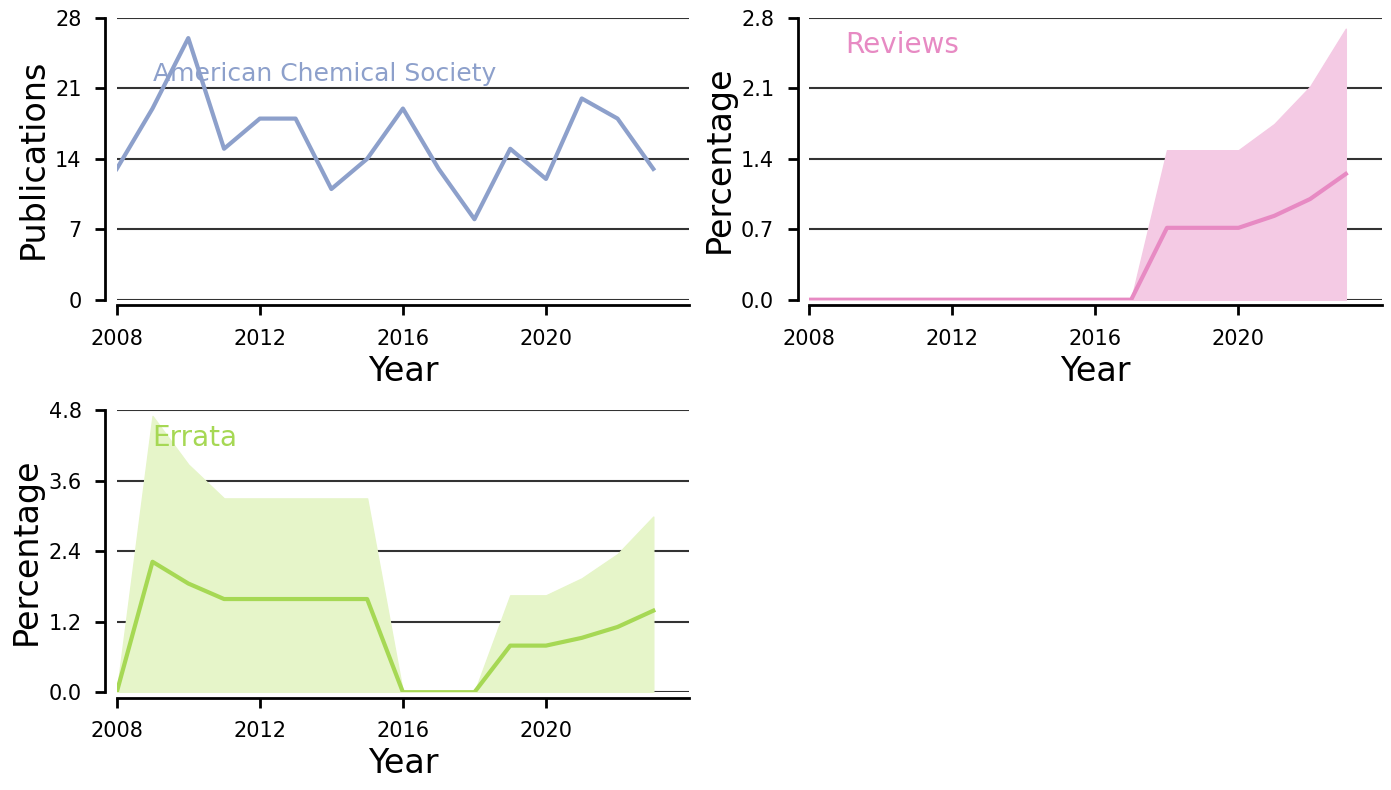

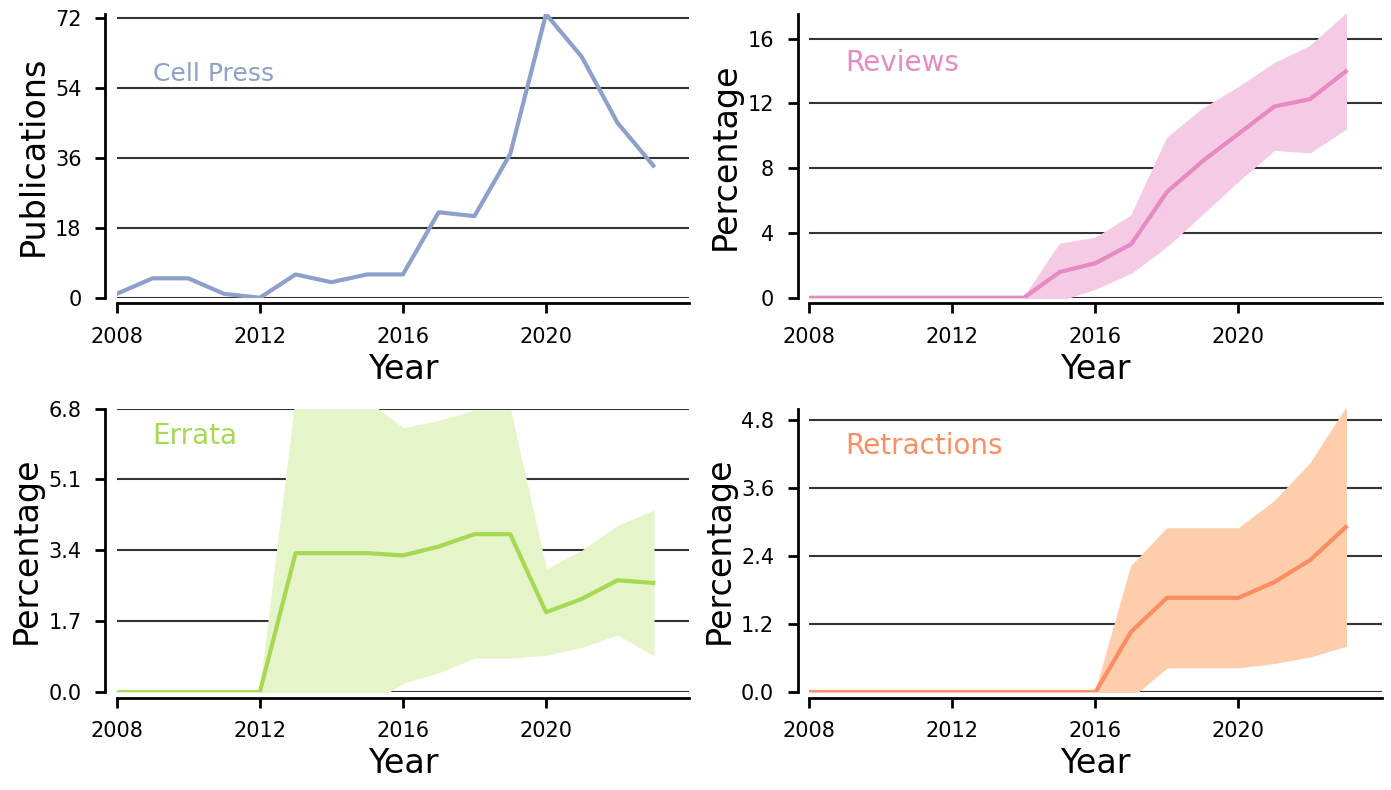

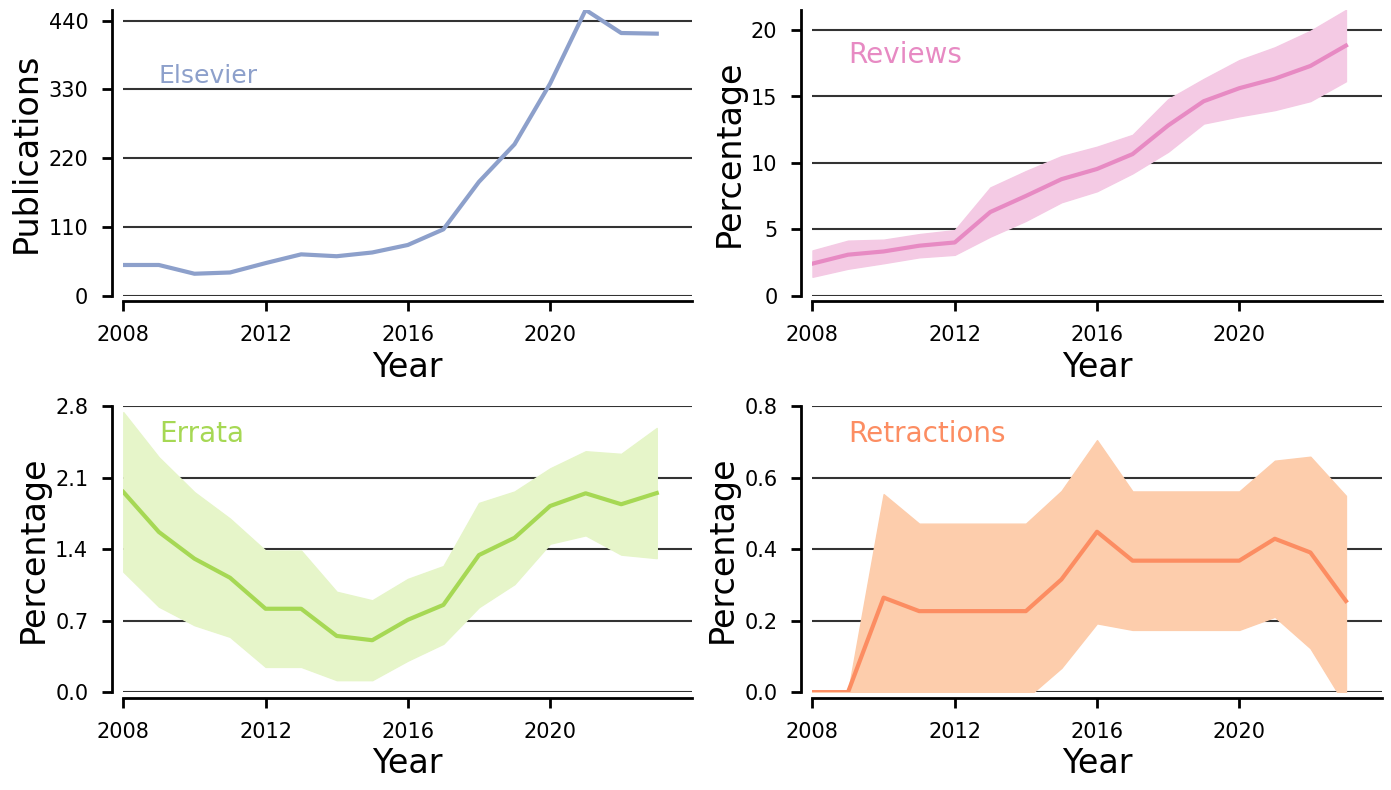

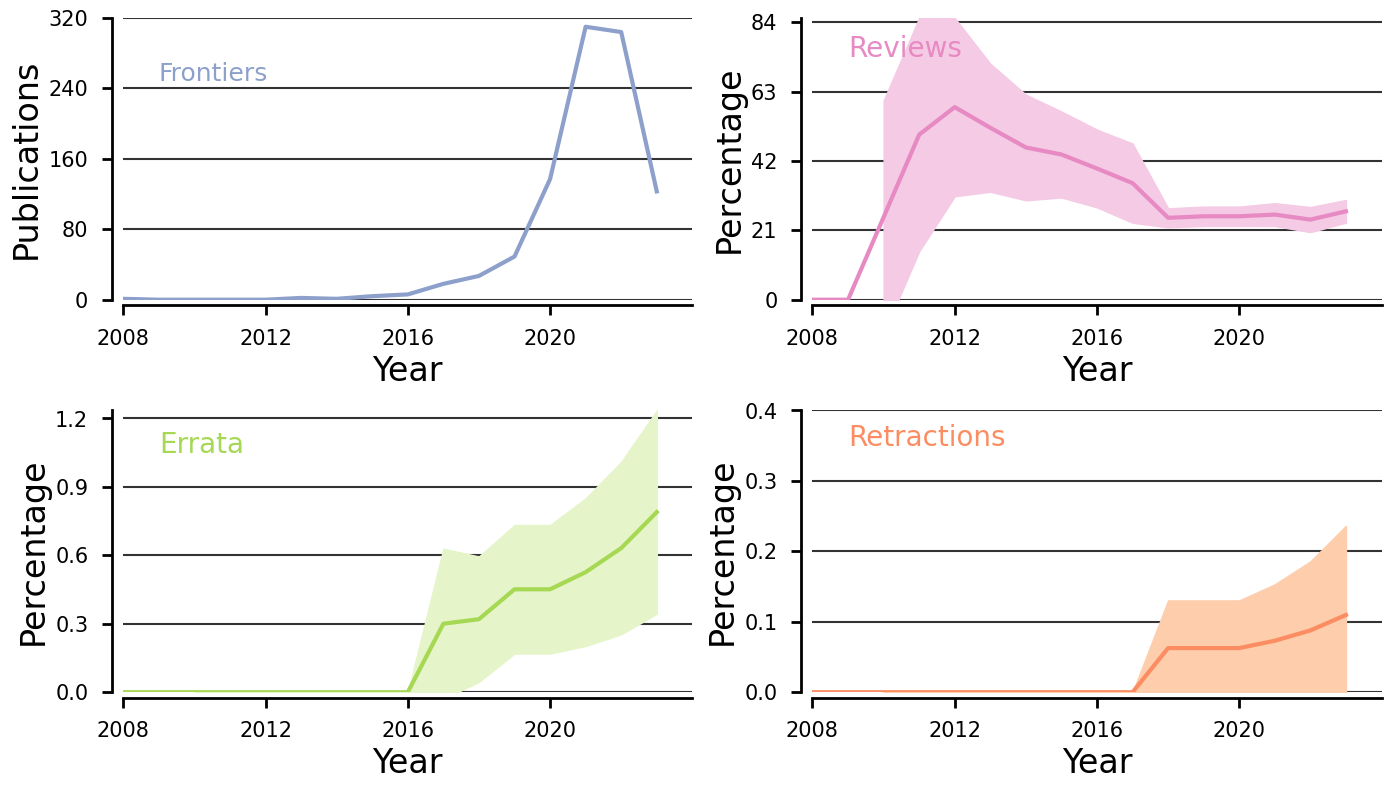

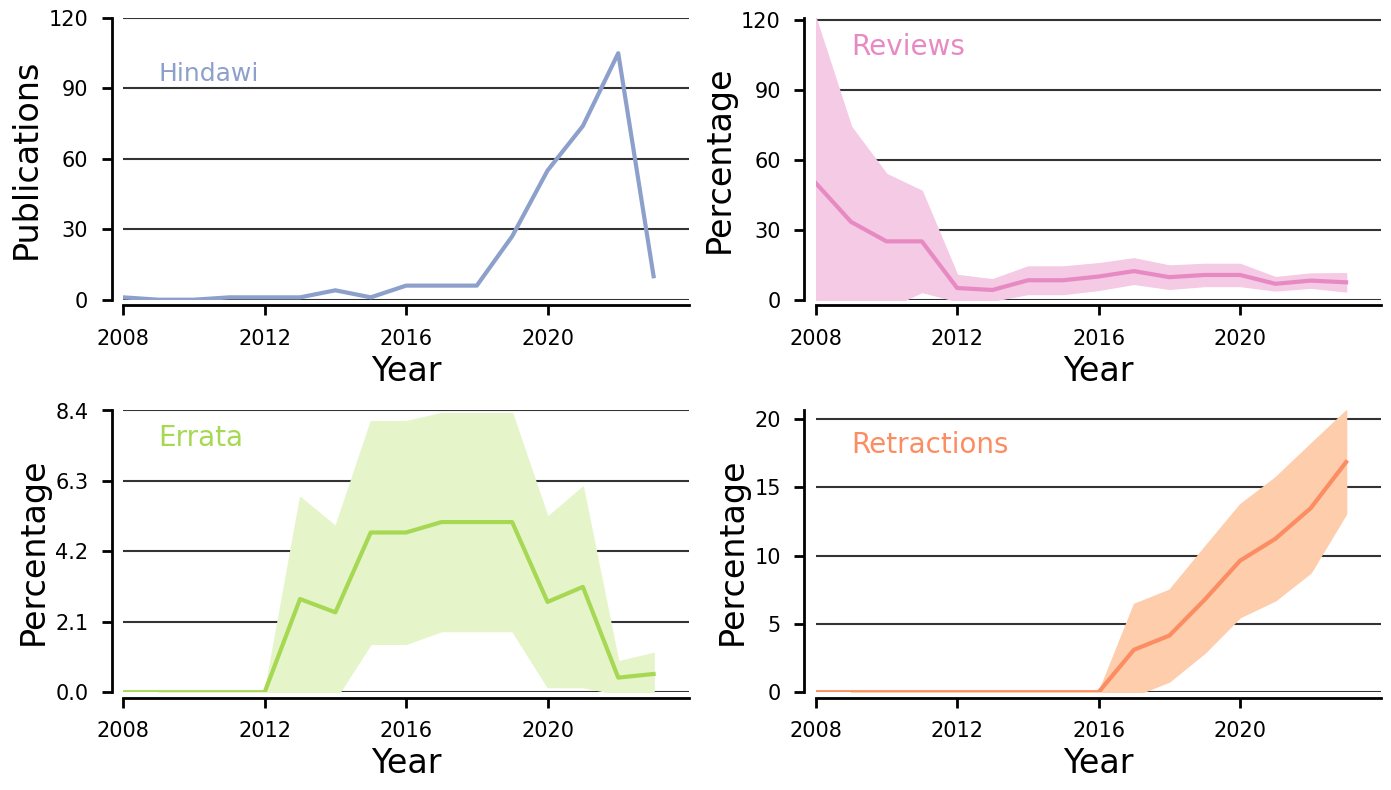

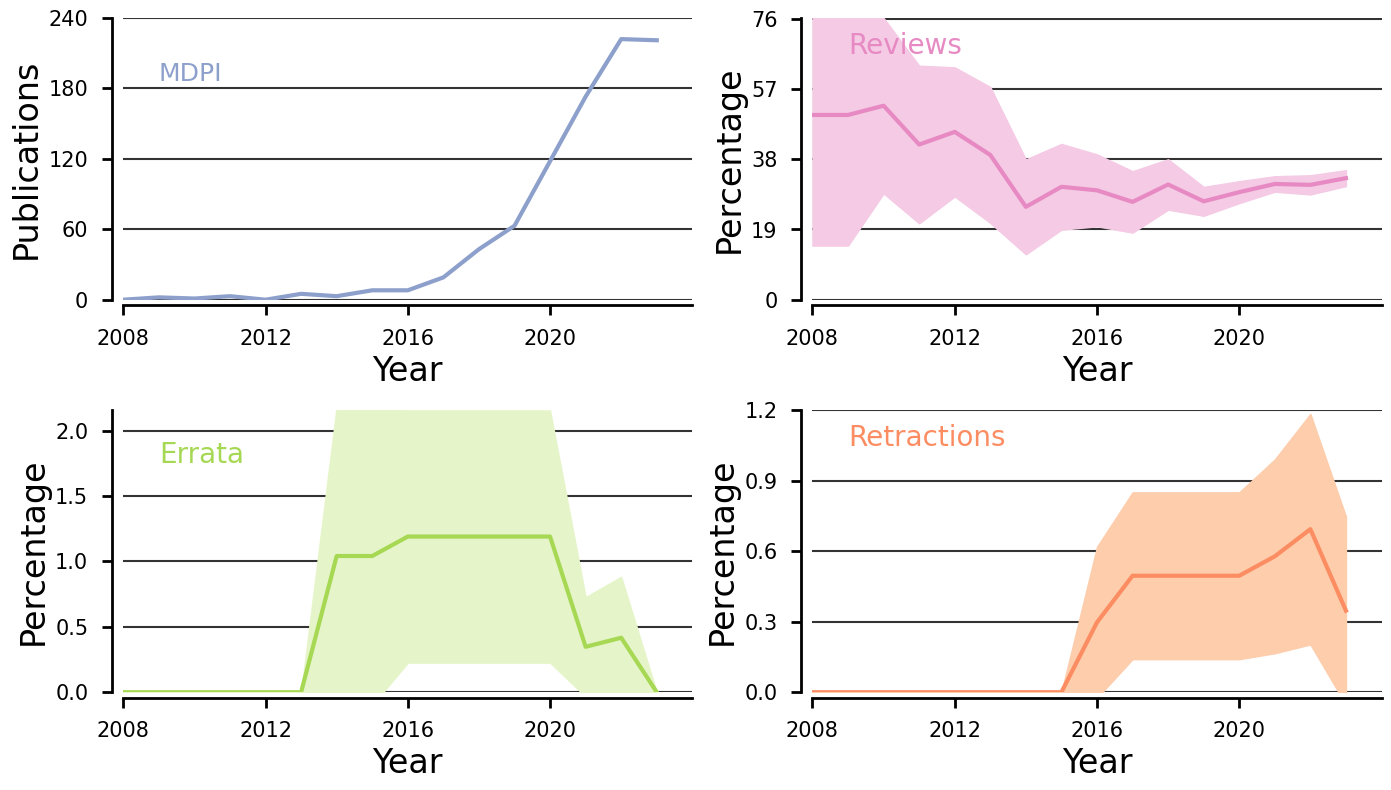

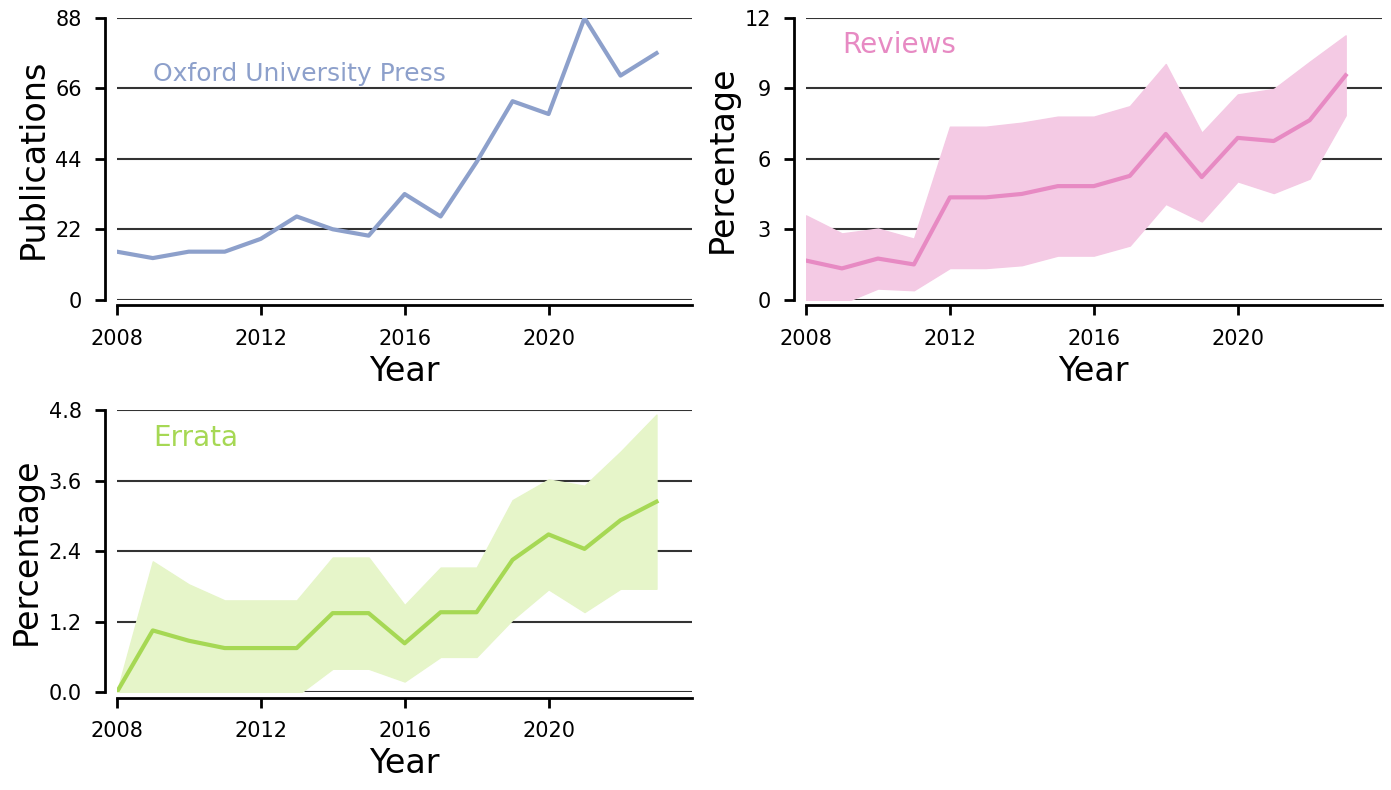

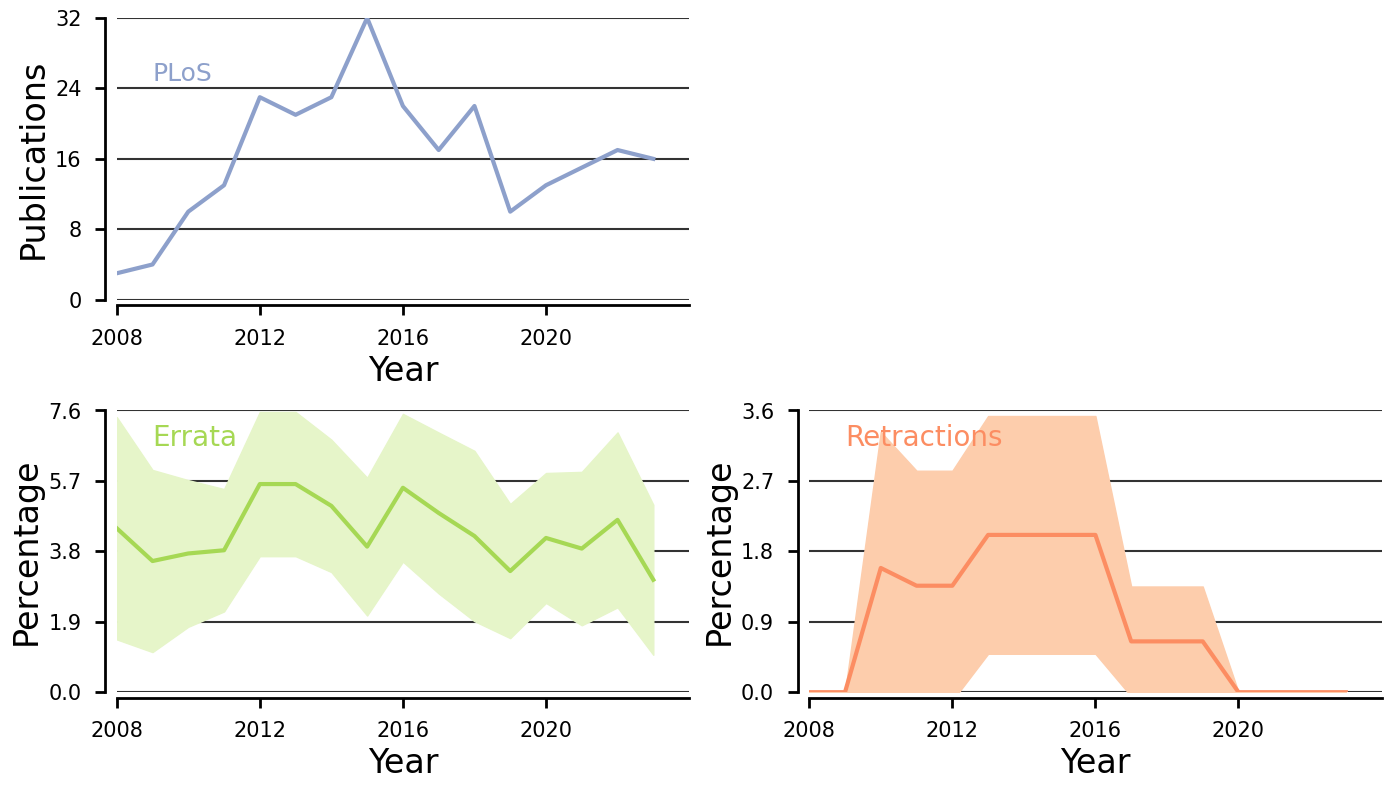

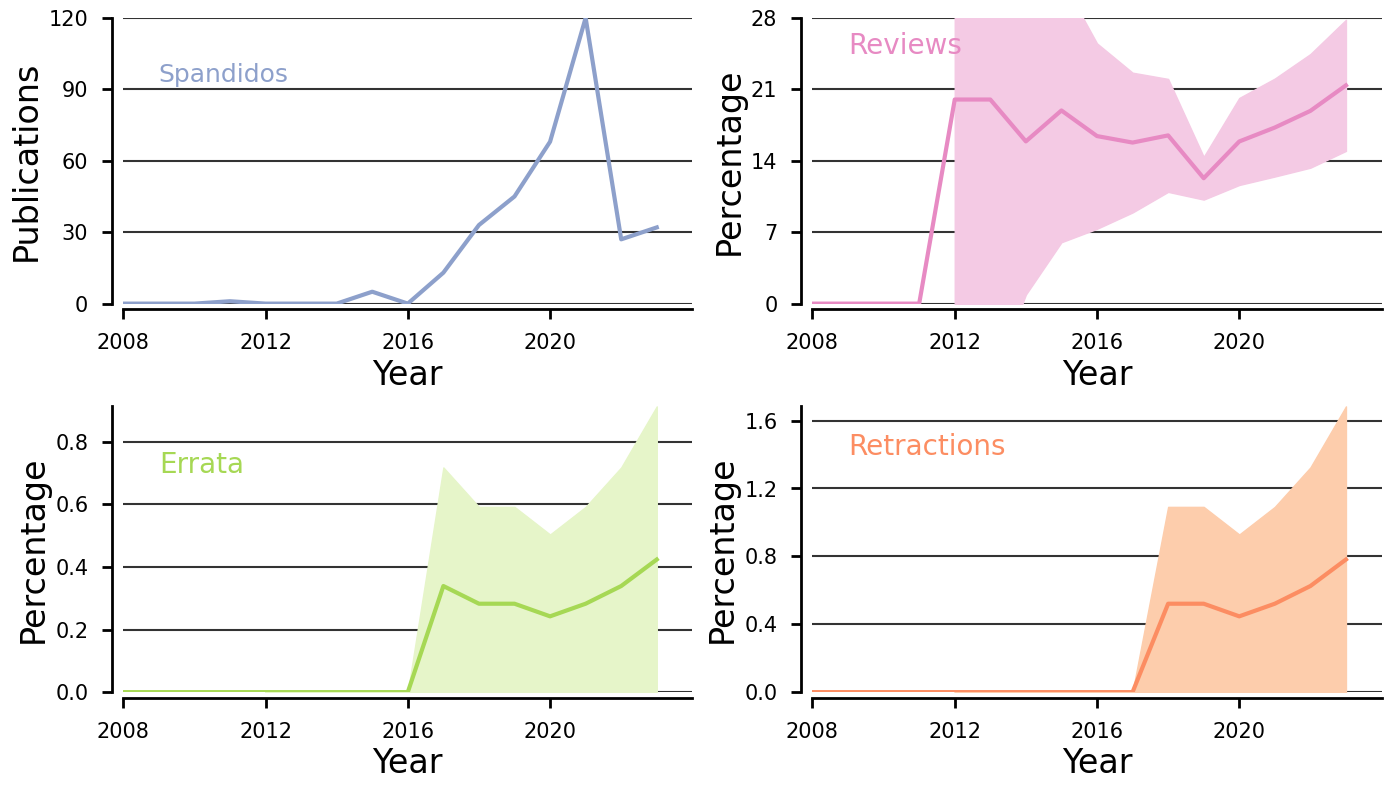

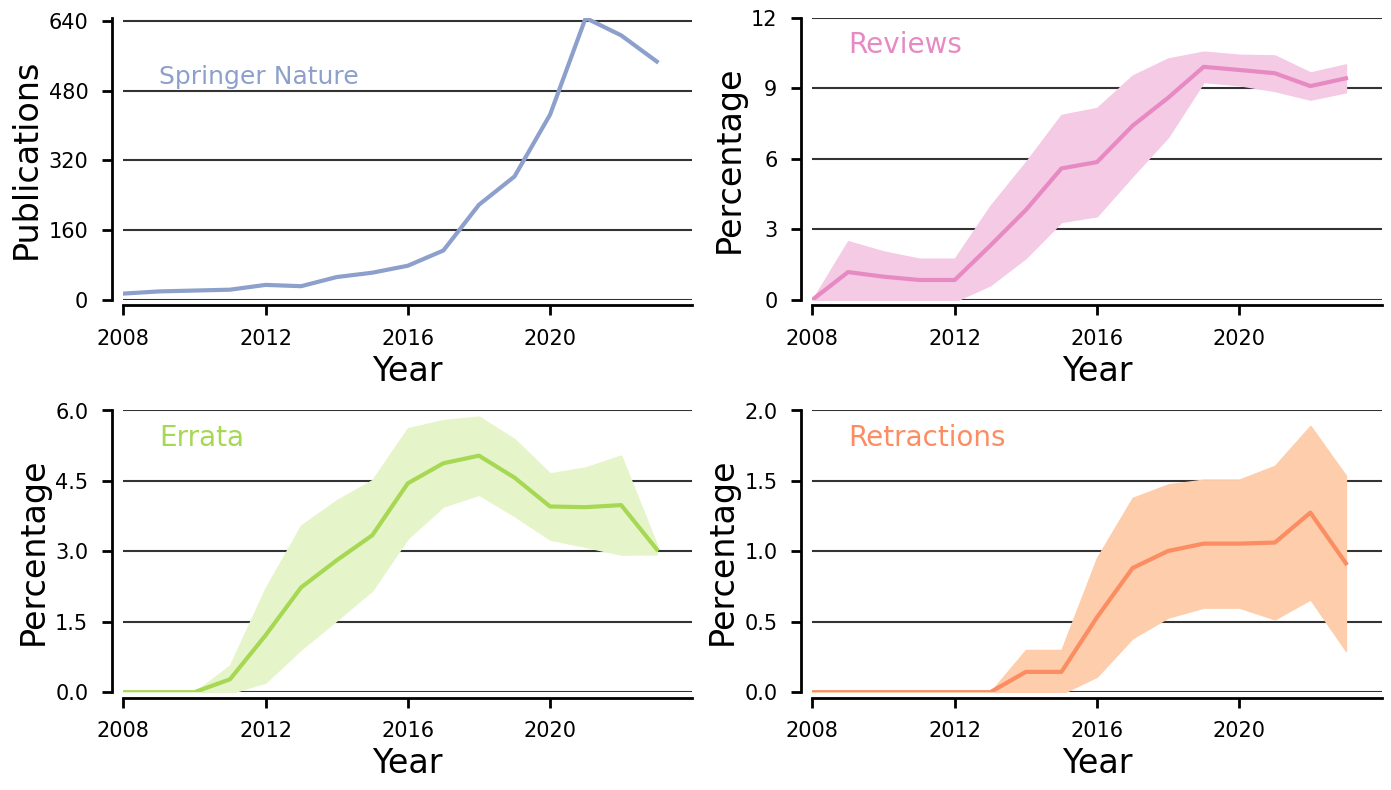

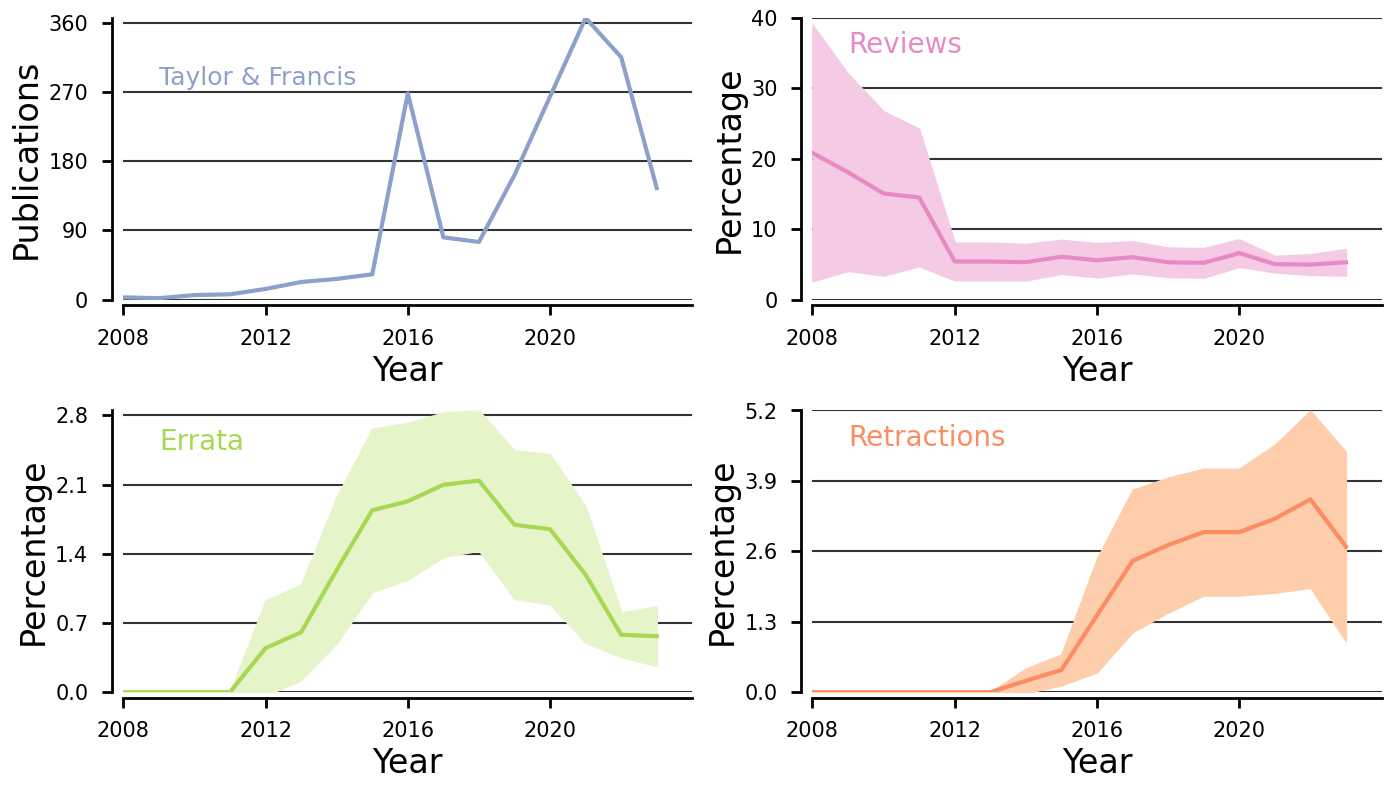

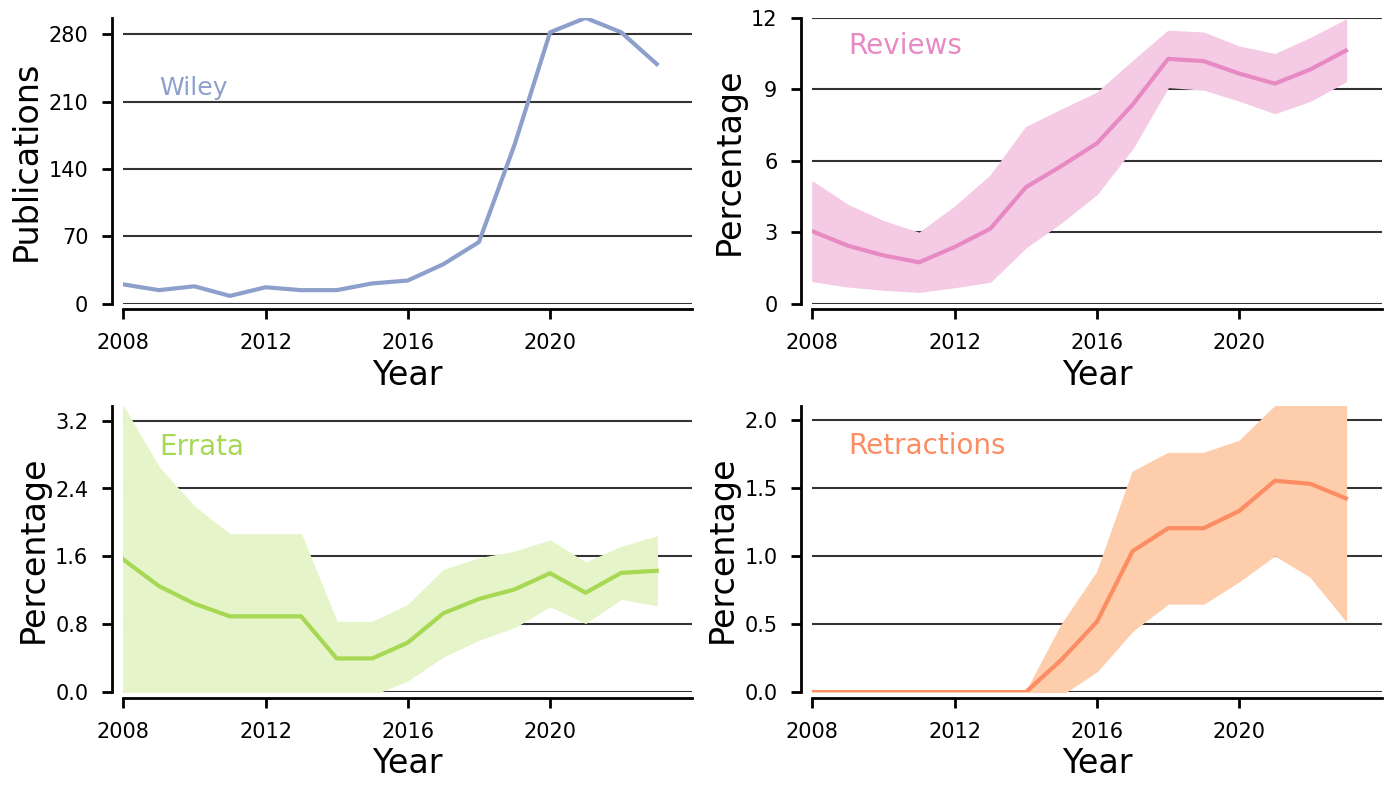

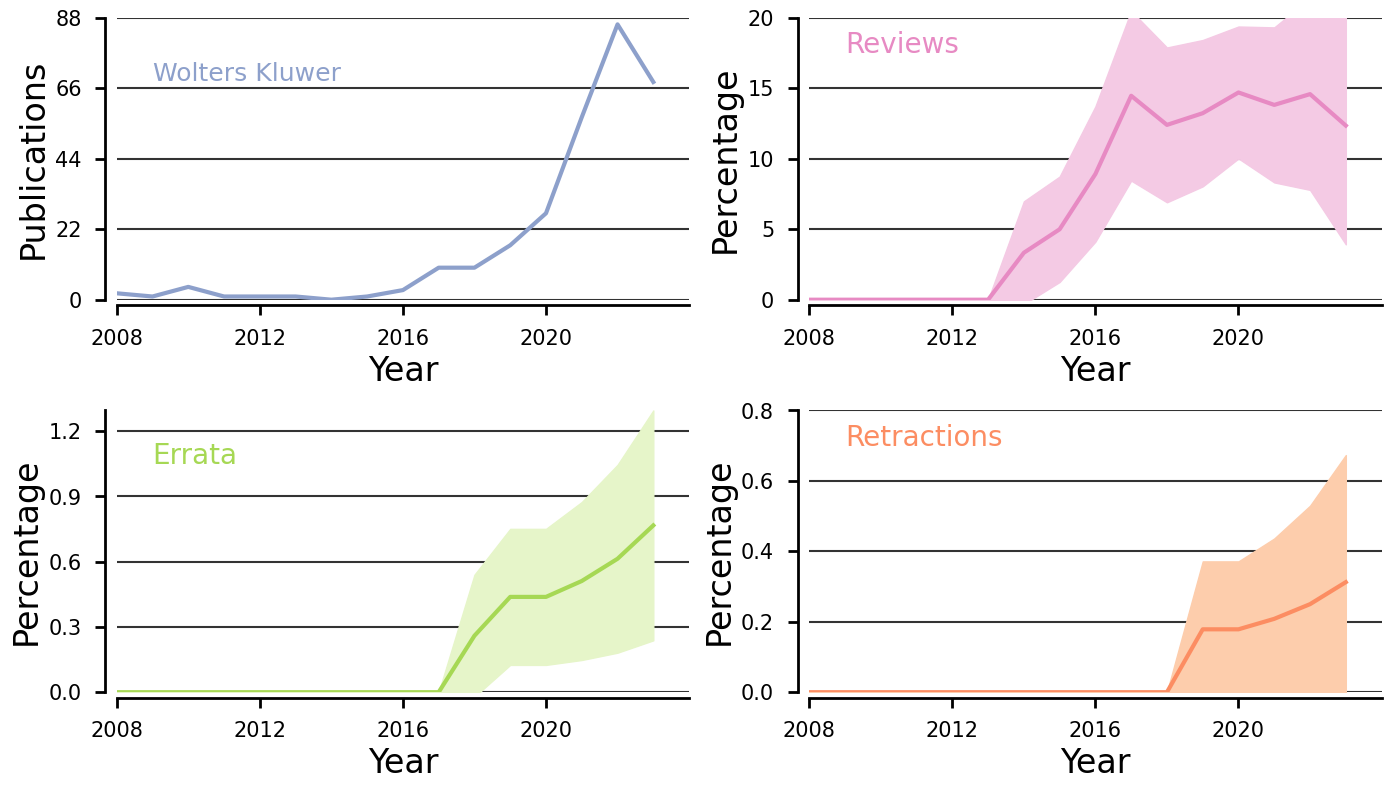

In [157]:
for publisher in sorted( publisher_list ): 
    target_articles = []
    for article in articles:
        if article['publisher']:
            if article['publisher'] == publisher:
                target_articles.append( article )

    print(f"\nThere are {len(target_articles)} articles in the set for "
          f"{publisher}")

    if len(target_articles) < min_size:
        continue
        
    pattern1 = 'review'
    pattern2 = 'reviewed'

    # Full set 
    #
    output = classify_articles( target_articles, 'FULL' )
    no_abstract_all, retracted_all, erratum_all, commented_all = output

    # Review articles set
    #
    review_articles = []
    for article in target_articles:
        if article['abstract']:
            if ( pattern1 in article['abstract'].lower() 
                 or pattern2 in article['abstract'].lower() ):
                review_articles.append( article )

    output = classify_articles( review_articles, 'REVIEW' )
    no_abstract_review, retracted_review, erratum_review, commented_review = output

    # No review articles set
    #
    no_review_articles = []
    for article in target_articles:
        if article['abstract']:
            if not ( pattern1 in article['abstract'].lower() 
                     or pattern2 in article['abstract'].lower() ):
                no_review_articles.append( article )

    output = classify_articles( no_review_articles, 'NO REVIEW' )
    no_abstract_norev, retracted_norev, erratum_norev, commented_norev = output

    df_target = pd.DataFrame( {'Year': array(range(year0, year1)), 
                                'Full Set Papers': get_time_series(pd.DataFrame(target_articles), year0, year1),
                                'FS Retracted': get_time_series(pd.DataFrame(retracted_all), year0, year1), 
                                'FS Errata': get_time_series(pd.DataFrame(erratum_all), year0, year1),
                                'FS Comments': get_time_series(pd.DataFrame(commented_all), year0, year1),
                                'Review Papers': get_time_series(pd.DataFrame(review_articles), year0, year1),
                                'Rev Retracted': get_time_series(pd.DataFrame(retracted_review), year0, year1), 
                                'Rev Errata': get_time_series(pd.DataFrame(erratum_review), year0, year1),
                                'Rev Comments': get_time_series(pd.DataFrame(commented_review), year0, year1),
                                'No Review Papers': get_time_series(pd.DataFrame(no_review_articles), year0, year1),
                                'NoRev Retracted': get_time_series(pd.DataFrame(retracted_norev), year0, year1), 
                                'NoRev Errata': get_time_series(pd.DataFrame(erratum_norev), year0, year1),
                                'NoRev Comments': get_time_series(pd.DataFrame(commented_norev), year0, year1),
                               } )

    key = 'Review Papers'
    column = f"{key}_ratio"
    df_target[column] = df_target[key] / df_target['Full Set Papers']

    for key in [ 'NoRev Retracted', 'NoRev Errata', 'NoRev Comments' ]:
        column = f"{key}_ratio"
        df_target[column] = df_target[key] / df_target['No Review Papers']

    colors = { 'Papers': '#8da0cb', 'Retracted': '#fc8d62', 'Reviews': '#e78ac3',
               'Errata': '#a6d854', 'Comments': '#66c2a5', }

    colors_b = { 'Papers': '#cbd5e8', 'Retracted': '#fdcdac', 'Reviews': '#f4cae4',
                 'Errata': '#e6f5c9', 'Comments': '#b3e2cd', }

    fig = plt.figure( figsize = (14, 8) )
    ax = []


    ax.append(fig.add_subplot(221))
    plot_time_series( ax[-1], df_target, 'Full Set Papers', 1, 
                      publisher,
                      colors['Papers'], colors_b['Papers'] )
    
    # Add exponential fit
    df_target['ln_Papers'] = log(df_target['Full Set Papers'])
    model = ols( formula = 'ln_Papers ~ Year', data = df_target)
    results = model.fit()
    if add_fit:
        ax[-1].plot( df_target.Year, 
                     exp(results.params.Intercept + results.params.Year * df_target.Year),
                     lw = 3, color = '0.2', zorder = -3)   

    if df_target['Review Papers_ratio'].count() > 0:
        ax.append(fig.add_subplot(222))
        plot_time_series( ax[-1], df_target, 'Review Papers_ratio', 7, 
                          'Reviews', colors['Reviews'], 
                          colors_b['Reviews'] )

    if df_target['NoRev Retracted_ratio'].count() > 0:
        ax.append(fig.add_subplot(224))
        plot_time_series( ax[-1], df_target, 'NoRev Retracted_ratio', 7, 
                          'Retractions', colors['Retracted'], 
                          colors_b['Retracted'] )

    if df_target['NoRev Errata_ratio'].count() > 0:
        ax.append(fig.add_subplot(223))
        plot_time_series( ax[-1], df_target, 'NoRev Errata_ratio', 7, 
                          'Errata', colors['Errata'], 
                          colors_b['Errata'] )

    plt.tight_layout()
    plt.savefig(Path.cwd() / folder / 'Publishers' / f"time_series_{publisher}.png")

# Generate figure for paper

## Generate main figure for topics

In [13]:
figure_params = [ {'folder': cwd / 'Case_crispr_cas9',
                   'year1': 2012, 'year2': 2023, 'min_size': 100, 'add_fit': False},
                  {'folder': cwd / 'Case_trna_development',
                   'year1': 2000, 'year2': 2023, 'min_size': 70, 'add_fit': False},
                  {'folder': cwd / 'Case_trna_cancer',
                   'year1': 2000, 'year2': 2023, 'min_size': 70, 'add_fit': False},
                  {'folder': cwd / 'Case_circular_rna',
                   'year1': 2008, 'year2': 2023, 'min_size': 250, 'add_fit': False},
                  {'folder': cwd / 'Case_mirna_development',
                   'year1': 2004, 'year2': 2023, 'min_size': 400, 'add_fit': False},
                  {'folder': cwd / 'Case_mirna_cancer',
                   'year1': 2004, 'year2': 2023, 'min_size': 650, 'add_fit': False},
                  {'folder': cwd / 'Case_lncrna',
                   'year1': 2008, 'year2': 2023, 'min_size': 400, 'add_fit': False},
                ]

There are 25868 articles in the 'NO REVIEW' set.
0 have no abstract; 
18 have been retracted; 
496 have had errata published; and 
107 have had comments written about them.


4435
5.0
There are 9241 articles in the 'NO REVIEW' set.
0 have no abstract; 
9 have been retracted; 
129 have had errata published; and 
29 have had comments written about them.


1002
5.0
There are 5919 articles in the 'NO REVIEW' set.
0 have no abstract; 
27 have been retracted; 
100 have had errata published; and 
19 have had comments written about them.


529
5.0
There are 15980 articles in the 'NO REVIEW' set.
0 have no abstract; 
191 have been retracted; 
289 have had errata published; and 
37 have had comments written about them.


3268
5.0
There are 45599 articles in the 'NO REVIEW' set.
0 have no abstract; 
689 have been retracted; 
848 have had errata published; and 
138 have had comments written about them.


7183
5.0
There are 68753 articles in the 'NO REVIEW' set.
0 have no abstract; 
1832 have been 

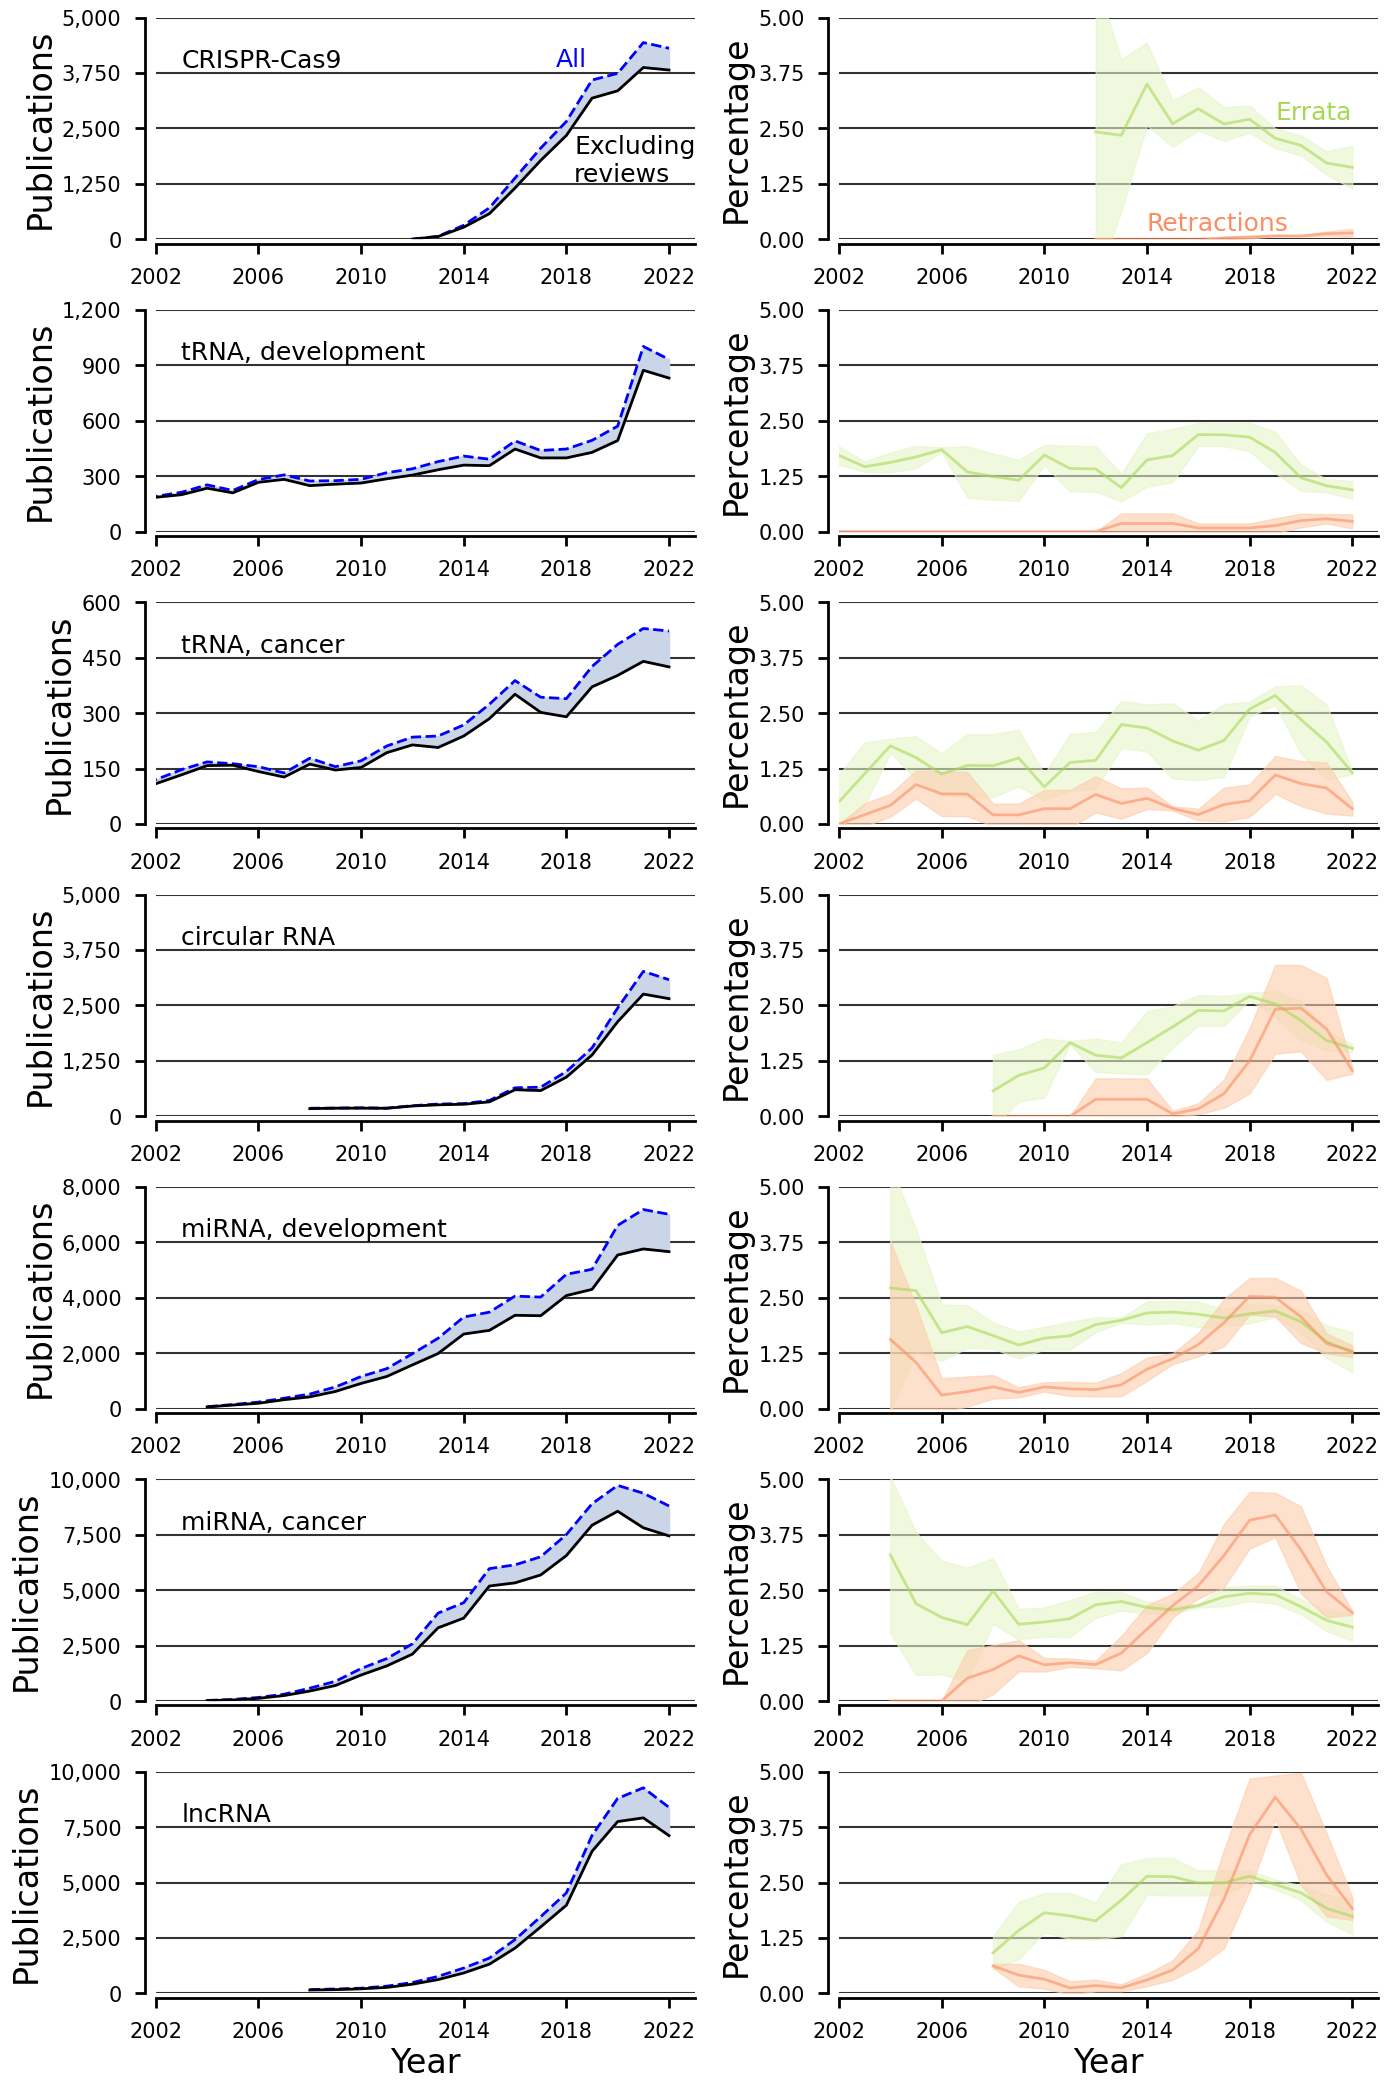

In [52]:
colors = { 'Papers': '#8da0cb', 'Retracted': '#fc8d62', 'Reviews': '#e78ac3',
           'Errata': '#a6d854', 'Comments': '#66c2a5', }

colors_b = { 'Papers': '#cbd5e8', 'Retracted': '#fdcdac', 'Reviews': '#f4cae4',
             'Errata': '#e6f5c9', 'Comments': '#b3e2cd', }

fig = plt.figure( figsize = (14, 21) )
ax = []

for j, case in enumerate( figure_params ):
    case_folder = case['folder']
    folder = case_folder.parts[-1]
    year0 = case['year1']
    year1 = case['year2']

    # Load data
    #
    articles_file = case_folder / 'articles_clean.json'
    with open(articles_file, 'r', encoding = 'utf-8') as f_json:
        articles = json.load(f_json)

    pattern1 = 'review'
    pattern2 = 'reviewed'

    # All articles
    #
    
    # No review articles set
    #
    no_review_articles = []
    for article in articles:
        if article['abstract']:
            if not ( pattern1 in article['abstract'].lower() 
                     or pattern2 in article['abstract'].lower() ):
                no_review_articles.append( article )

    output = classify_articles( no_review_articles, 'NO REVIEW' )
    no_abstract_norev, retracted_norev, erratum_norev, commented_norev = output

    # Create dataframe with time series 
    #
    df_time_series = pd.DataFrame( {'Year': array(range(year0, year1)), 
                                    'Full Set Papers': get_time_series(pd.DataFrame(articles), year0, year1),
                                    'No Review Papers': get_time_series(pd.DataFrame(no_review_articles), year0, year1),
                                    'NoRev Retracted': get_time_series(pd.DataFrame(retracted_norev), year0, year1), 
                                    'NoRev Errata': get_time_series(pd.DataFrame(erratum_norev), year0, year1),
                                   } )

    for key in [ 'NoRev Retracted', 'NoRev Errata' ]:
        column = f"{key}_ratio"
        df_time_series[column] = df_time_series[key] / df_time_series['No Review Papers']

    # Plot data
    #
    y_max = 5.
    x_label = ''
    if j == 6: 
        x_label = 'Year'
    
    y_label = 'Percentage'
        
    my_text = folder[5:].lower().replace('rna', 'RNA').replace('_',', ')
    my_text = my_text.replace('crispr, cas9', 'CRISPR-Cas9')
    my_text = my_text.replace('circular,', 'circular')
    ax.append(fig.add_subplot(len(figure_params), 2, 2*j+1))
    plot_for_publications( ax[-1], df_time_series, my_text, colors_b['Papers'],
                           x_label )


    ax.append(fig.add_subplot(len(figure_params), 2, 2*j+2))
    plot_for_problems( ax[-1], df_time_series, 
                       colors['Retracted'], colors['Errata'],
                       colors_b['Retracted'], colors_b['Errata'], 
                       x_label, y_label, y_max, 3  )


    
# Add legend:
ax[0].text(2018.8, 3900, 'All', color = 'b', ha = 'right', fontsize = 18)
ax[0].text(2018.3, 1300, 'Excluding\nreviews', fontsize = 18)

ax[1].text(2019, 2.7, 'Errata', color = colors['Errata'], fontsize = 18)
ax[1].text(2014, 0.2, 'Retractions', color = colors['Retracted'], fontsize = 18)

plt.tight_layout()
plt.savefig(cwd / 'fig-retractions_errata.pdf')

## Generate figure for publishers

We will be processing the data in folder 'Case_crispr_cas9'.

There are 29,394 articles in the 'Case_crispr_cas9' collection.

Finished processing all articles.

We lack publisher information for 2,348 articles.

There are 4448 articles in the set for Elsevier
There are 3796 articles in the 'NO REVIEW' set.
0 have no abstract; 
2 have been retracted; 
58 have had errata published; and 
11 have had comments written about them.


1
15

There are 1735 articles in the set for Frontiers
There are 1367 articles in the 'NO REVIEW' set.
0 have no abstract; 
2 have been retracted; 
23 have had errata published; and 
1 have had comments written about them.


2
15

There are 474 articles in the set for Taylor & Francis
There are 357 articles in the 'NO REVIEW' set.
0 have no abstract; 
1 have been retracted; 
6 have had errata published; and 
1 have had comments written about them.


3
15
We will be processing the data in folder 'Case_trna_development'.

There are 10,277 articles in the 'Case_trn

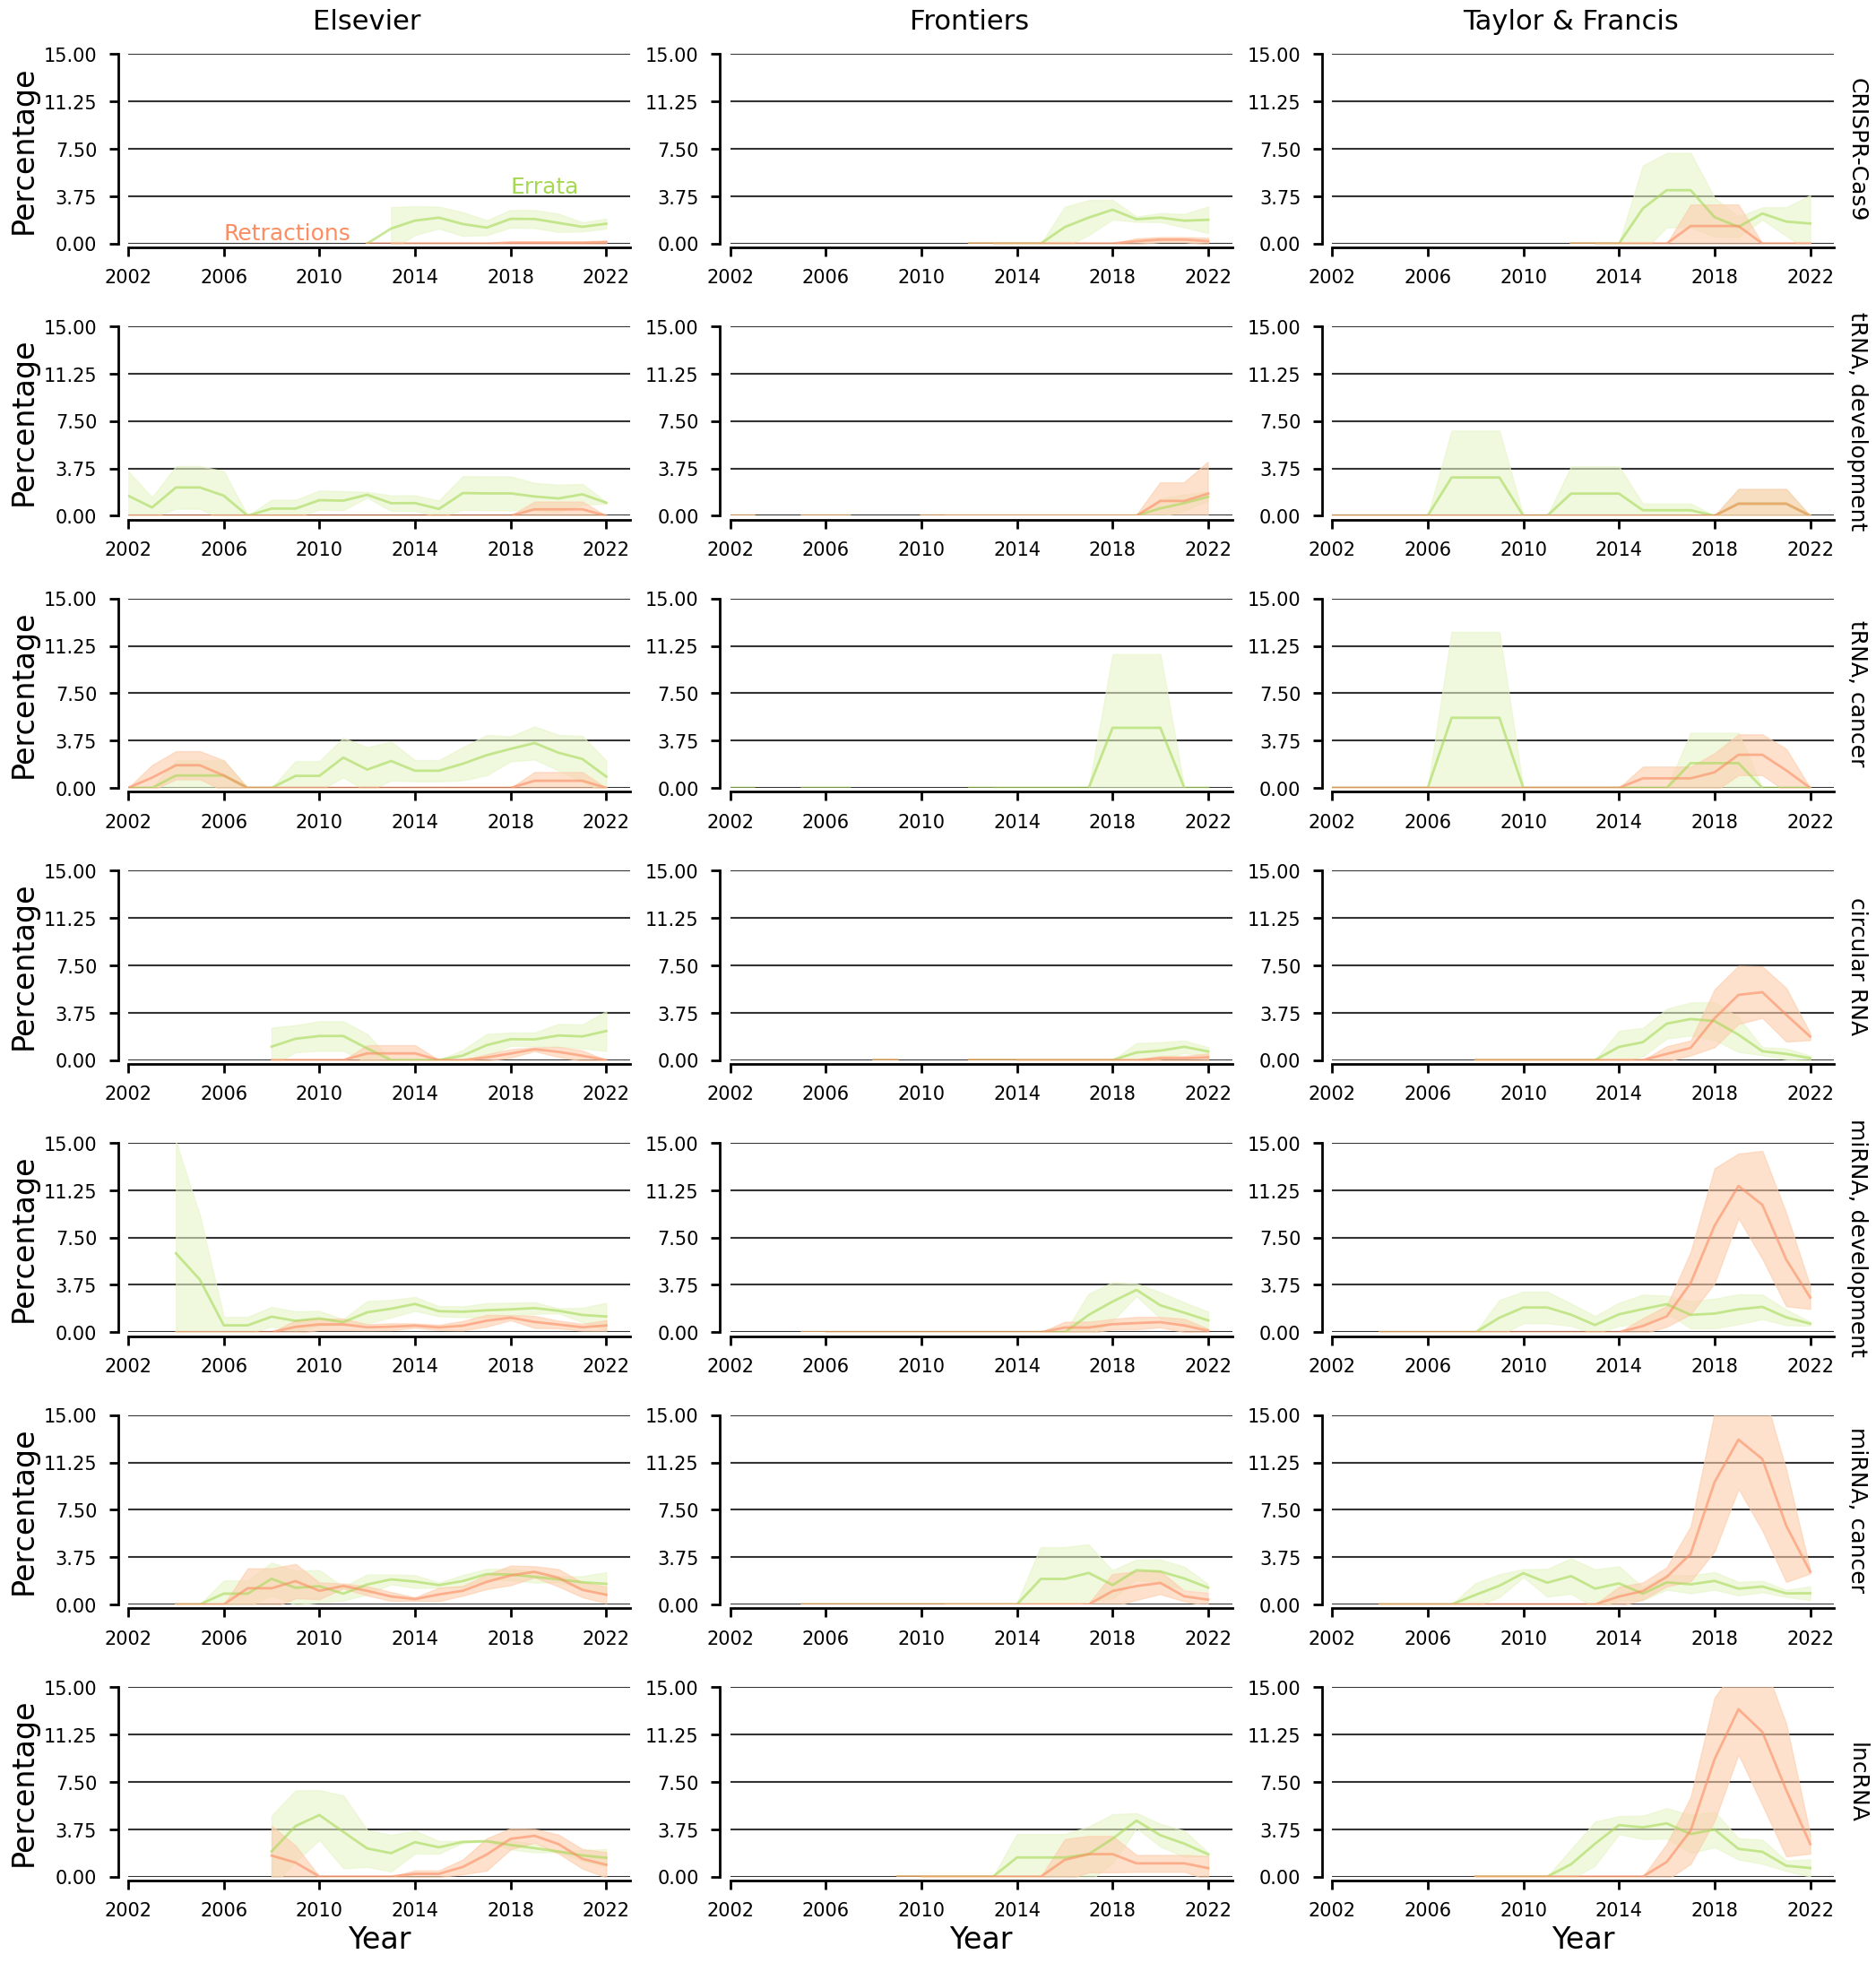

In [50]:
colors = { 'Papers': '#8da0cb', 'Retracted': '#fc8d62', 'Reviews': '#e78ac3',
           'Errata': '#a6d854', 'Comments': '#66c2a5', }

colors_b = { 'Papers': '#cbd5e8', 'Retracted': '#fdcdac', 'Reviews': '#f4cae4',
             'Errata': '#e6f5c9', 'Comments': '#b3e2cd', }

fig = plt.figure( figsize = (21, 22) )
ax = []

for j, case in enumerate( figure_params ):
    case_folder = case['folder']
    folder = case_folder.parts[-1]
    year0 = case['year1']
    year1 = case['year2']

    # Load data
    #
    print(f"We will be processing the data in folder '{case['folder'].parts[-1]}'.\n")
    articles_file = case_folder / 'articles_clean.json'
    with open(articles_file, 'r', encoding = 'utf-8') as f_json:
        articles = json.load(f_json)

    print( f"There are {place_commas(len(articles))} articles in the "
           f"'{case['folder'].parts[-1]}' collection.\n" )

    # Assign publishers to articles
    #
    no_info = []
    for i, article in enumerate( articles ):
        journal = article['journal']
        
        journal_info = catalogue[journal]
        
        # We lack info for some journals
        #
        if journal_info['publisher'] is None:
            no_info.append(i)
            for key in ['publisher', 'start_date', 'mesh']:
                article[key] = None
    
            continue
        
        for key in ['publisher', 'start_date', 'mesh']:
            if key not in journal_info.keys():
                article[key] = None
            else:
                article[key] = journal_info[key]
            
    print(f"Finished processing all articles.\n\n"
          f"We lack publisher information for {place_commas(len(no_info))} articles.")

    # Conduct analysis for selected publishers
    #
    for k, publisher in enumerate( ['Elsevier', 'Frontiers', 'Taylor & Francis'] ):
        target_articles = []
        for article in articles:
            if 'publisher' in article.keys() and article['publisher']:
                if article['publisher'] == publisher:
                    target_articles.append( article )
    
        print(f"\nThere are {len(target_articles)} articles in the set for "
              f"{publisher}")

        pattern1 = 'review'
        pattern2 = 'reviewed'

        # No review articles set
        #
        no_review_articles = []
        for article in target_articles:
            if article['abstract']:
                if not ( pattern1 in article['abstract'].lower() 
                         or pattern2 in article['abstract'].lower() ):
                    no_review_articles.append( article )

        output = classify_articles( no_review_articles, 'NO REVIEW' )
        no_abstract_norev, retracted_norev, erratum_norev, commented_norev = output
    
        # Create dataframe with time series 
        #
        df_time_series = pd.DataFrame( {'Year': array(range(year0, year1)), 
                                    'Full Set Papers': get_time_series(pd.DataFrame(articles), year0, year1),
                                    'No Review Papers': get_time_series(pd.DataFrame(no_review_articles), year0, year1),
                                    'NoRev Retracted': get_time_series(pd.DataFrame(retracted_norev), year0, year1), 
                                    'NoRev Errata': get_time_series(pd.DataFrame(erratum_norev), year0, year1),
                                   } )

        for key in [ 'NoRev Retracted', 'NoRev Errata' ]:
            column = f"{key}_ratio"
            df_time_series[column] = df_time_series[key] / df_time_series['No Review Papers']

        # Plot data
        #
        y_max = 15
        x_label = ''
        if j == 6: 
            x_label = 'Year'

        if k == 0:
            y_label = 'Percentage'
        else:
            y_label = ''
            
        my_text = folder[5:].lower().replace('rna', 'RNA').replace('_',', ')
        my_text = my_text.replace('crispr, cas9', 'CRISPR-Cas9')
        my_text = my_text.replace('circular,', 'circular')

        ax_number = (3 * j) + 1 + k
        print(ax_number)
        try:
            ax.append( fig.add_subplot(len(figure_params), 3, ax_number) )
            plot_for_problems( ax[-1], df_time_series, 
                               colors['Retracted'], colors['Errata'],
                               colors_b['Retracted'], colors_b['Errata'], 
                               x_label, y_label, y_max, 3  )
            
            if j == 0:
                ax[-1].text( 2012, 17, publisher, fontsize = 22, ha = 'center' )

            if k == 2:
                ax[-1].text( 2023.5, 7.5, my_text, fontsize = 18, va = 'center',
                             rotation = -90 )

        except TypeError:
            # del ax[-1]
            continue
            
# Add legend:
ax[0].text(2018, 4.0, 'Errata', color = colors['Errata'], fontsize = 18)
ax[0].text(2006, 0.3, 'Retractions', color = colors['Retracted'], fontsize = 18)

plt.tight_layout()
plt.savefig(cwd / 'fig-retractions_errata-publishers.pdf')

# Analyze trends relating to publisher type

In [ ]:
target_publishers = [ 'Frontiers', 'Hindawi', 'IOS Press', 
                      'Mary Ann Liebert', 'MDPI', ]

In [ ]:
target_publishers = [ 'American Association for Cancer Research', 
                      'American Medical Association', 
                      'American Chemical Society', 
                      'Cell Press', 'Elsevier', 'FASEB', 'Nature Springer',
                      'Oxford University Press', 
                      'Nature Springer', 
                      'PLoS', 'Royal Society of Chemistry',
                      'Taylor & Francis', ]

# 'Wiley' for skin
# Nature Springer and 'Oxford University Press' dramatically increase
# fraction of reviews over the period for BRAC2


In [ ]:
target_publishers = ['American Society of Clinical Oncology']

In [ ]:
target_code = str(target_publishers).replace(', ', '_').replace("'", '').strip('[]')
print(target_code)

target_articles = []
for article in articles:
    if article['publisher']:
        if article['publisher'] in target_publishers:
            target_articles.append( article )    

print(f"\nThere are {len(target_articles)} articles in the set for "
      f"publishers:\n\t{target_code}")

In [ ]:
pattern1 = 'review'
pattern2 = 'reviewed'

# Full set 
#
output = classify_articles( target_articles, 'FULL' )
no_abstract_all, retracted_all, erratum_all, commented_all = output

# Review articles set
#
review_articles = []
for article in target_articles:
    if article['abstract']:
        if ( pattern1 in article['abstract'].lower() 
             or pattern2 in article['abstract'].lower() ):
            review_articles.append( article )

output = classify_articles( review_articles, 'REVIEW' )
no_abstract_review, retracted_review, erratum_review, commented_review = output

# No review articles set
#
no_review_articles = []
for article in target_articles:
    if article['abstract']:
        if not ( pattern1 in article['abstract'].lower() 
                 or pattern2 in article['abstract'].lower() ):
            no_review_articles.append( article )

output = classify_articles( no_review_articles, 'NO REVIEW' )
no_abstract_norev, retracted_norev, erratum_norev, commented_norev = output

## Create dataframe with time series 

In [ ]:
# year0, year1 = 2006, 2021
year0, year1 = 2000, 2024
# year0, year1 = 2010, 2024

df_target = pd.DataFrame( {'Year': array(range(year0, year1)), 
                            'Full Set Papers': get_time_series(pd.DataFrame(target_articles), year0, year1),
                            'FS Retracted': get_time_series(pd.DataFrame(retracted_all), year0, year1), 
                            'FS Errata': get_time_series(pd.DataFrame(erratum_all), year0, year1),
                            'FS Comments': get_time_series(pd.DataFrame(commented_all), year0, year1),
                            'Review Papers': get_time_series(pd.DataFrame(review_articles), year0, year1),
                            'Rev Retracted': get_time_series(pd.DataFrame(retracted_review), year0, year1), 
                            'Rev Errata': get_time_series(pd.DataFrame(erratum_review), year0, year1),
                            'Rev Comments': get_time_series(pd.DataFrame(commented_review), year0, year1),
                            'No Review Papers': get_time_series(pd.DataFrame(no_review_articles), year0, year1),
                            'NoRev Retracted': get_time_series(pd.DataFrame(retracted_norev), year0, year1), 
                            'NoRev Errata': get_time_series(pd.DataFrame(erratum_norev), year0, year1),
                            'NoRev Comments': get_time_series(pd.DataFrame(commented_norev), year0, year1),
                           } )

df_target



## Calculate ratios

In [ ]:
key = 'Review Papers'
column = f"{key}_ratio"
df_target[column] = df_target[key] / df_target['Full Set Papers']
    
for key in [ 'NoRev Retracted', 'NoRev Errata', 'NoRev Comments' ]:
    column = f"{key}_ratio"
    df_target[column] = df_target[key] / df_target['No Review Papers']


## Plot data

In [ ]:
colors = { 'Papers': '#8da0cb', 'Retracted': '#fc8d62', 'Reviews': '#e78ac3',
           'Errata': '#a6d854', 'Comments': '#66c2a5', }

colors_b = { 'Papers': '#cbd5e8', 'Retracted': '#fdcdac', 'Reviews': '#f4cae4',
             'Errata': '#e6f5c9', 'Comments': '#b3e2cd', }

fig = plt.figure( figsize = (14, 8) )
ax = []

ax.append(fig.add_subplot(221))
plot_time_series( ax[-1], df_target, 'Full Set Papers', 1, 
                         folder.replace('_', ' '), colors['Papers'], 
                         colors_b['Papers'] )
# ax[-1].semilogy()

ax.append(fig.add_subplot(222))
plot_time_series( ax[-1], df_target, 'NoRev Retracted_ratio', 7, 
                        'Retractions', colors['Retracted'], 
                        colors_b['Retracted'] )

ax.append(fig.add_subplot(223))
plot_time_series( ax[-1], df_target, 'Review Papers_ratio', 7, 
                        'Reviews', colors['Reviews'], 
                        colors_b['Reviews'] )
# ax[-1].semilogy()

ax.append(fig.add_subplot(224))
# plot_time_series( ax[-1], df_target, 'NoRev Comments_ratio', 5, 
#                          'Comments', colors['Comments'], 
#                         colors_b['Comments'] )

plot_time_series( ax[-1], df_target, 'NoRev Errata_ratio', 7, 
                        'Errata', colors['Errata'], 
                        colors_b['Errata'] )

plt.tight_layout()

plt.savefig(Path.cwd() / folder / f"time_series_{target_code}.png")